# Gentrification in New Orleans - Leah Kuperman and Leo Simanonok

https://leosimanonok.github.io/DataScienceFinalTutorial/

&nbsp;&nbsp;&nbsp;&nbsp;Throughout the past decade, data science has emerged as a leading field of study and industry. Data analysis has become critical in tackling societal problems and 
tracking certain trends in order to arrive at informed, logical solutions. For our final project, we have decided to study New Orleans income and property data 
to identify the prevalence of gentrification in different neighborhoods. As Tulane students, it is easy to become trapped in the uptown bubble and forget about the 
impact we have on the rest of the city’s people, economy, and culture. It is no secret that New Orleans as a whole is a victim of gentrification. Part of what makes 
the city so unique is its rich history and resilience, something to which none of the 13,000 people from out of state who have moved here from 2012-2016 can bear 
witness. That being said, our goal for this project is to find meaningful insights in our datasets which we can offer to our partners, hopefully inspiring positive 
changes in New Orleans.
<br>
&nbsp;&nbsp;&nbsp;&nbsp;Initially, one of the datasets we hoped to get our hands on was property value data. Looking at housing prices would allow us take a holistic look at gentrification
and possibly track the movement of affluent people to previously poorer neighborhoods. Unfortunately, property value data is notoriously hard to collect in New 
Orleans. Because of this, the first dataset we analyzed involves poverty rates and income data. To this end, we found census data from the years 2010-2018 which estimates 
the median income and poverty rate of every county in the USA. Another dataset we decided to look into is a census tract dataset containing both racial and income data. Finally, a third dataset we are looking at analyzes similar statistics from a level of different neighborhoods in and around New Orleans. We hope to use this data in conjunction with 
the previously discussed census data in order to show how gentrification changes the make-up of neighborhoods. Ideally, we would like to show where the displaced 
citizens moved after their neighborhoods were gentrified. 
<br>
&nbsp;&nbsp;&nbsp;&nbsp;The two datasets we decided to load into our notebook for this milestone contain the average income and racial makeup for each census tract and each neighborhood. Loading this datasets 
came with a host of struggles. The biggest struggle was changing all of the column names such that they were sensical and easy to manipulate.
<br>
&nbsp;&nbsp;&nbsp;&nbsp;In terms of our meeting plan, we have set weekly meetings on Mondays at 1pm to analyze our progress and plan for any upcoming due dates or milestones. Depending on 
our availability and wellbeing, we have decided to meet in person in the library to avoid technological complications. In the event that we need to meet virtually, we will maintain these meeting times via Zoom. For any code we are writing for the final project, we will do so in our private GitHub repo attached to our final project page. We have already established that both of us are able to connect, pull, and push to it from our local machines.

## References/Links
https://www.census.gov/programs-surveys/saipe/data/api.html<br>
https://www.census.gov/data/datasets/time-series/demo/saipe/model-tables.html<br>
https://www.datacenterresearch.org/reports_analysis/placing-prosperity/<br>
https://richcampanella.com/wp-content/uploads/2020/02/article_Campanella_300-Years-of-Human-Geography-in-New-Orleans.pdf<br>
https://www.nytimes.com/2019/08/27/opinion/new-orleans.html <br>
https://data.census.gov/cedsci/
https://github.com/uscensusbureau/citysdk/blob/master/v2/GeoJSON/500k/2019/18/tract.json
https://tigerweb.geo.census.gov/tigerwebmain/TIGERweb_apps.html

Original data can be found on our github page in ~/Data

In [61]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import random as rand
matplotlib.style.use('ggplot')#style change
%matplotlib inline
pd.options.mode.chained_assignment = None #ignore warnings
pd.options.display.float_format = '{:.4f}'.format #display in non-scientific notation

In [62]:
import geopandas as gpd
import folium as fl
from pandas.io.json import json_normalize
import json

**Source** <br>
Original data tables can be found by searching for "race" and "income" at https://data.census.gov/cedsci/ and the filtering to only include census tracts in orleans parish.

We begin by cleaning up a dataset of one year of race data, which we will then apply to each year of data.

In [63]:
df = pd.read_csv("./Data/productDownload_2020-10-23T150453/ACSDP5Y2010.DP05_data_with_overlays_2020-10-23T150427.csv", skiprows = 1)
# change names of columns I want to keep, and then make them into new df
clean_df = df.rename(columns = {
    "id" : "Geo_ID",
    "Geographic Area Name" : "Census Tract",
    "Estimate!!SEX AND AGE!!Total population" : "Total Population",
    "Estimate!!RACE!!One race!!White" : "White",
    "Estimate!!RACE!!One race!!Black or African American" : "Black",
    "Estimate!!RACE!!One race!!American Indian and Alaska Native" : "American Indian and Alask Native",
    "Estimate!!RACE!!One race!!Asian" : "Asian",
    "Estimate!!RACE!!One race!!Native Hawaiian and Other Pacific Islander" : "Native Hawaiian and Other Pacific Islander",
    "Estimate!!RACE!!One race!!Some other race" : "Other"
    
    

    
    
})
clean_df = clean_df[["Geo_ID", "Census Tract", "Total Population", "White", "Black", "American Indian and Alask Native",
                   "Asian", "Native Hawaiian and Other Pacific Islander", "Other"]]

# get rid of extra characters from census tract column
clean_df["Census Tract"] = clean_df["Census Tract"].map(lambda x: x.lstrip('Census Tract').rstrip('Orleans Parish, Louisiana'))
clean_df["Year"] = 2010
# get rid of unnecessary numbers in Geo_ID
clean_df["Geo_ID"] = clean_df["Geo_ID"].apply(lambda x: x[9:])
clean_df["Geo_ID"] = clean_df["Geo_ID"].astype(np.int64)
clean_df["Census Tract"] = clean_df["Census Tract"].astype(np.float64)

In [64]:
# get all race data into one df
all_clean_race_df = clean_df

for i in range(2011, 2019):
    year = str(i)
    fileName = "./Data/productDownload_2020-10-23T150453/ACSDP5Y" + year + ".DP05_data_with_overlays_2020-10-23T150427.csv"
    df = pd.read_csv(fileName, skiprows=1)
    new_df = df.rename(columns = {
        "id" : "Geo_ID",
        "Geographic Area Name" : "Census Tract",
        "Estimate!!SEX AND AGE!!Total population" : "Total Population",
        "Estimate!!RACE!!One race!!White" : "White",
        #different names in different tables
        "Estimate!!RACE!!Total population!!One race!!White" : "White",
        "Estimate!!RACE!!One race!!Black or African American" : "Black",
        "Estimate!!RACE!!Total population!!One race!!Black or African American" : "Black",
        "Estimate!!RACE!!One race!!American Indian and Alaska Native" : "American Indian and Alask Native",
        "Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native" : "American Indian and Alask Native",
        "Estimate!!RACE!!One race!!Asian" : "Asian",
        "Estimate!!RACE!!Total population!!One race!!Asian" : "Asian",
        "Estimate!!RACE!!One race!!Native Hawaiian and Other Pacific Islander" : "Native Hawaiian and Other Pacific Islander",
        "Estimate!!RACE!!Total population!!One race!!Native Hawaiian and Other Pacific Islander" : "Native Hawaiian and Other Pacific Islander",
        "Estimate!!RACE!!One race!!Some other race" : "Other",
        "Estimate!!RACE!!Total population!!One race!!Some other race" : "Other"
    })
    # keep race data
    new_df = new_df[["Geo_ID", "Census Tract", "Total Population", "White", "Black", "American Indian and Alask Native", "Asian", "Native Hawaiian and Other Pacific Islander", "Other"]]
    # get rid of words in census tract column
    new_df["Census Tract"] = new_df["Census Tract"].map(lambda x: x.lstrip('Census Tract').rstrip('Orleans Parish, Louisiana'))
    # get rid of unnecessary numbers in Geo_ID
    new_df["Geo_ID"] = new_df["Geo_ID"].apply(lambda x: x[9:])
    new_df["Geo_ID"] = new_df["Geo_ID"].astype(np.int64)
    new_df["Census Tract"] = new_df["Census Tract"].astype(np.float64)
    new_df["Year"] = i
    all_clean_race_df = pd.concat([all_clean_race_df, new_df], ignore_index=True)

We will now check that the data type of each column makes sense.

In [65]:
print(all_clean_race_df.dtypes)

Geo_ID                                          int64
Census Tract                                  float64
Total Population                                int64
White                                           int64
Black                                           int64
American Indian and Alask Native                int64
Asian                                           int64
Native Hawaiian and Other Pacific Islander      int64
Other                                           int64
Year                                            int64
dtype: object


Note: Some census tracts are split into parts, like in the example below, so they are kept as floats, rather than ints.

In [66]:
all_clean_race_df[44:46]

,Geo_ID,Census Tract,Total Population,White,Black,American Indian and Alask Native,Asian,Native Hawaiian and Other Pacific Islander,Other,Year
44,22071012101,121.0100,3343,2721,212,0,317,0,0,2010
45,22071012102,121.0200,4236,3694,161,0,281,0,0,2010


We can now look at the data from one census tract from 2010 to 2018

In [67]:
all_clean_race_df[all_clean_race_df["Census Tract"] == 65]

,Geo_ID,Census Tract,Total Population,White,Black,American Indian and Alask Native,Asian,Native Hawaiian and Other Pacific Islander,Other,Year
3,22071006500,65.0000,2126,933,1031,8,0,22,102,2010
283,22071006500,65.0000,2315,1181,840,14,36,46,134,2011
460,22071006500,65.0000,2569,1398,844,17,32,53,116,2012
569,22071006500,65.0000,2620,1500,740,10,38,37,209,2013
862,22071006500,65.0000,2679,1627,802,0,40,26,94,2014
943,22071006500,65.0000,2761,1782,772,0,35,0,116,2015
1168,22071006500,65.0000,2709,1785,741,0,27,0,97,2016
1292,22071006500,65.0000,2782,1712,899,0,28,0,101,2017
1522,22071006500,65.0000,2762,1631,905,0,23,0,128,2018


We will save this dataframe to a csv, so that we can skip this cleaning in the future.

In [68]:
all_clean_race_df.to_csv("./Data/cleaned_race_data.csv")

We can now start cleaning the income dataset.

In [69]:
df = pd.read_csv("./Data/productDownload_2020-10-23T151012/ACSST5Y2010.S1901_data_with_overlays_2020-10-23T150937.csv", skiprows=1)

In [70]:
clean_df = df.rename(columns = {
    "id" : "Geo_ID",
    "Geographic Area Name" : "Census Tract",
    #households or families?
    "Households!!Estimate!!Total" : "Households",
    "Households!!Estimate!!Less than $10,000" : "Households less than $\$$10,000",
    "Households!!Estimate!!$10,000 to $14,999" : "Households $\$$10,000 to $\$$14,999",
    "Households!!Estimate!!$15,000 to $24,999" : "Households $\$$15,000 to $\$$24,999",
    "Households!!Estimate!!$25,000 to $34,999" : "Households $\$$25,000 to $\$$34,999",
    "Households!!Estimate!!$35,000 to $49,999" : "Households $\$$35,000 to $\$$49,999",
    "Households!!Estimate!!$50,000 to $74,999" : "Households $\$$50,000 to $\$$74,999",
    "Households!!Estimate!!$75,000 to $99,999" : "Households $\$$75,000 to $\$$99,999",
    "Households!!Estimate!!$100,000 to $149,999" : "Households $\$$100,000 to $\$$149,999",
    "Households!!Estimate!!$150,000 to $199,999" : "Households $\$$150,000 to $\$$199,999",
    "Households!!Estimate!!$200,000 or more" : "Households $\$$200,000 or more",
    "Households!!Estimate!!Median income (dollars)" : "Household median income (dollars)",
    "Households!!Estimate!!Mean income (dollars)" : "Household mean income (dollars)",
})

clean_df = clean_df[["Geo_ID", "Census Tract", "Households", "Households less than $\$$10,000", "Households $\$$10,000 to $\$$14,999",
                    "Households $\$$15,000 to $\$$24,999", "Households $\$$25,000 to $\$$34,999", "Households $\$$35,000 to $\$$49,999",
                    "Households $\$$50,000 to $\$$74,999", "Households $\$$75,000 to $\$$99,999", "Households $\$$100,000 to $\$$149,999",
                     "Households $\$$150,000 to $\$$199,999", "Households $\$$200,000 or more", "Household median income (dollars)",
                     "Household mean income (dollars)"]]
clean_df.replace(to_replace="-", value=np.nan, inplace=True)
clean_df.replace(to_replace="N", value=np.nan, inplace=True)
clean_df = clean_df.astype({
        "Households" : "int64",
        "Households less than $\$$10,000" :  "float64",
        "Households $\$$10,000 to $\$$14,999" : "float64",
        "Households $\$$15,000 to $\$$24,999" : "float64",
        "Households $\$$25,000 to $\$$34,999" : "float64",
        "Households $\$$35,000 to $\$$49,999" : "float64",
        "Households $\$$50,000 to $\$$74,999" : "float64",
        "Households $\$$75,000 to $\$$99,999" : "float64", 
        "Households $\$$100,000 to $\$$149,999" : "float64",
        "Households $\$$150,000 to $\$$199,999" : "float64", 
        "Households $\$$200,000 or more" : "float64",
        "Household median income (dollars)" : "float64",
        "Household mean income (dollars)" : "float64"
    })

clean_df["Census Tract"] = clean_df["Census Tract"].map(lambda x: x.lstrip('Census Tract').rstrip('Orleans Parish, Louisiana'))
clean_df["Year"] = 2010      
# get rid of unnecessary numbers in Geo_ID
clean_df["Geo_ID"] = clean_df["Geo_ID"].apply(lambda x: x[9:])
clean_df["Geo_ID"] = clean_df["Geo_ID"].astype(np.int64)
clean_df["Census Tract"] = clean_df["Census Tract"].astype(np.float64)

Now we add all the other years.

In [71]:
all_clean_income_df = clean_df

for i in range(2011, 2019):
    year = str(i)
    fileName = "./Data/productDownload_2020-10-23T151012/ACSST5Y" + year + ".S1901_data_with_overlays_2020-10-23T150937.csv"
    df = pd.read_csv(fileName, skiprows=1)
    new_df = df.rename(columns = {
        "id" : "Geo_ID",
        "Geographic Area Name" : "Census Tract",
        #households or families?
        "Households!!Estimate!!Total" : "Households",
        #different starting in 2017
        "Estimate!!Households!!Total" : "Households",
        "Households!!Estimate!!Less than $10,000" : "Households less than $\$$10,000",
        "Estimate!!Households!!Total!!Less than $10,000" : "Households less than $\$$10,000",
        "Households!!Estimate!!$10,000 to $14,999" : "Households $\$$10,000 to $\$$14,999",
        "Estimate!!Households!!Total!!$10,000 to $14,999" : "Households $\$$10,000 to $\$$14,999",
        "Households!!Estimate!!$15,000 to $24,999" : "Households $\$$15,000 to $\$$24,999",
        "Estimate!!Households!!Total!!$15,000 to $24,999" : "Households $\$$15,000 to $\$$24,999",
        "Households!!Estimate!!$25,000 to $34,999" : "Households $\$$25,000 to $\$$34,999",
        "Estimate!!Households!!Total!!$25,000 to $34,999" : "Households $\$$25,000 to $\$$34,999",
        "Households!!Estimate!!$35,000 to $49,999" : "Households $\$$35,000 to $\$$49,999",
        "Estimate!!Households!!Total!!$35,000 to $49,999" : "Households $\$$35,000 to $\$$49,999",
        "Households!!Estimate!!$50,000 to $74,999" : "Households $\$$50,000 to $\$$74,999",
        "Estimate!!Households!!Total!!$50,000 to $74,999" : "Households $\$$50,000 to $\$$74,999",
        "Households!!Estimate!!$75,000 to $99,999" : "Households $\$$75,000 to $\$$99,999",
        "Estimate!!Households!!Total!!$75,000 to $99,999" : "Households $\$$75,000 to $\$$99,999",
        "Households!!Estimate!!$100,000 to $149,999" : "Households $\$$100,000 to $\$$149,999",
        "Estimate!!Households!!Total!!$100,000 to $149,999" : "Households $\$$100,000 to $\$$149,999",
        "Households!!Estimate!!$150,000 to $199,999" : "Households $\$$150,000 to $\$$199,999",
        "Estimate!!Households!!Total!!$150,000 to $199,999" : "Households $\$$150,000 to $\$$199,999",
        "Households!!Estimate!!$200,000 or more" : "Households $\$$200,000 or more",
        "Estimate!!Households!!Total!!$200,000 or more" : "Households $\$$200,000 or more",
        "Households!!Estimate!!Median income (dollars)" : "Household median income (dollars)",
        "Estimate!!Households!!Median income (dollars)" : "Household median income (dollars)",
        "Households!!Estimate!!Mean income (dollars)" : "Household mean income (dollars)",
        "Estimate!!Households!!Mean income (dollars)" : "Household mean income (dollars)",
    })

    new_df = new_df[["Geo_ID", "Census Tract", "Households", "Households less than $\$$10,000", "Households $\$$10,000 to $\$$14,999",
                    "Households $\$$15,000 to $\$$24,999", "Households $\$$25,000 to $\$$34,999", "Households $\$$35,000 to $\$$49,999",
                    "Households $\$$50,000 to $\$$74,999", "Households $\$$75,000 to $\$$99,999", "Households $\$$100,000 to $\$$149,999",
                     "Households $\$$150,000 to $\$$199,999", "Households $\$$200,000 or more", "Household median income (dollars)",
                     "Household mean income (dollars)"]]
    # replace "-" with np.nan
    new_df.replace(to_replace="-", value=np.nan, inplace=True)
    new_df.replace(to_replace="N", value=np.nan, inplace=True)
    new_df = new_df.astype({
        "Households" : "int64",
        "Households less than $\$$10,000" :  "float64",
        "Households $\$$10,000 to $\$$14,999" : "float64",
        "Households $\$$15,000 to $\$$24,999" : "float64",
        "Households $\$$25,000 to $\$$34,999" : "float64",
        "Households $\$$35,000 to $\$$49,999" : "float64",
        "Households $\$$50,000 to $\$$74,999" : "float64",
        "Households $\$$75,000 to $\$$99,999" : "float64", 
        "Households $\$$100,000 to $\$$149,999" : "float64",
        "Households $\$$150,000 to $\$$199,999" : "float64", 
        "Households $\$$200,000 or more" : "float64",
        "Household median income (dollars)" : "float64",
        "Household mean income (dollars)" : "float64"
    })
    new_df["Census Tract"] = new_df["Census Tract"].map(lambda x: x.lstrip('Census Tract').rstrip('Orleans Parish, Louisiana'))
    # get rid of unnecessary numbers in Geo_ID
    new_df["Geo_ID"] = new_df["Geo_ID"].apply(lambda x: x[9:])
    new_df["Geo_ID"] = new_df["Geo_ID"].astype(np.int64)
    new_df["Census Tract"] = new_df["Census Tract"].astype(np.float64)
    new_df["Year"] = i
    all_clean_income_df = pd.concat([all_clean_income_df, new_df], ignore_index=True)

In [72]:
all_clean_income_df.dtypes

Geo_ID                                     int64
Census Tract                             float64
Households                                 int64
Households less than $\$$10,000          float64
Households $\$$10,000 to $\$$14,999      float64
Households $\$$15,000 to $\$$24,999      float64
Households $\$$25,000 to $\$$34,999      float64
Households $\$$35,000 to $\$$49,999      float64
Households $\$$50,000 to $\$$74,999      float64
Households $\$$75,000 to $\$$99,999      float64
Households $\$$100,000 to $\$$149,999    float64
Households $\$$150,000 to $\$$199,999    float64
Households $\$$200,000 or more           float64
Household median income (dollars)        float64
Household mean income (dollars)          float64
Year                                       int64
dtype: object

Note: All of the household data are percentages, which is why they are floats and not ints.

We can now look at the data across all years for one census tract.

In [73]:
all_clean_income_df[all_clean_income_df["Census Tract"] == 65]

,Geo_ID,Census Tract,Households,"Households less than $\$$10,000","Households $\$$10,000 to $\$$14,999","Households $\$$15,000 to $\$$24,999","Households $\$$25,000 to $\$$34,999","Households $\$$35,000 to $\$$49,999","Households $\$$50,000 to $\$$74,999","Households $\$$75,000 to $\$$99,999","Households $\$$100,000 to $\$$149,999","Households $\$$150,000 to $\$$199,999","Households $\$$200,000 or more",Household median income (dollars),Household mean income (dollars),Year
106,22071006500,65.0000,937,10.8000,9.9000,17.3000,9.8000,10.2000,20.2000,12.8000,4.7000,4.3000,0.0000,37440.0000,48102.0000,2010
283,22071006500,65.0000,1092,19.2000,9.9000,8.4000,10.9000,11.8000,16.4000,9.7000,9.1000,4.6000,0.0000,36932.0000,49805.0000,2011
460,22071006500,65.0000,1194,15.0000,10.1000,15.7000,11.2000,9.8000,14.5000,11.7000,10.1000,2.0000,0.0000,32226.0000,46976.0000,2012
637,22071006500,65.0000,1226,14.9000,9.8000,14.5000,11.0000,13.0000,17.5000,9.5000,8.5000,1.4000,0.0000,34817.0000,44878.0000,2013
781,22071006500,65.0000,1184,14.9000,7.9000,14.0000,12.9000,10.5000,15.2000,13.2000,10.2000,1.0000,0.3000,35256.0000,48322.0000,2014
940,22071006500,65.0000,1218,13.6000,5.9000,13.7000,12.3000,13.0000,15.4000,15.3000,9.6000,1.1000,0.2000,37368.0000,49714.0000,2015
1179,22071006500,65.0000,1199,6.8000,7.9000,15.8000,11.7000,14.9000,15.8000,12.8000,12.1000,1.1000,1.1000,40040.0000,54719.0000,2016
1292,22071006500,65.0000,1215,9.2000,7.3000,14.1000,11.5000,16.0000,11.4000,14.8000,11.2000,3.2000,1.2000,39250.0000,56894.0000,2017
1522,22071006500,65.0000,1228,8.0000,4.7000,15.0000,11.6000,11.2000,12.0000,15.5000,14.1000,6.1000,1.9000,49000.0000,64585.0000,2018


Finally, we export this dataframe to a csv, so that we can skip the cleaning steps in the future.

In [74]:
all_clean_income_df.to_csv("./Data/cleaned_income_data.csv")

In order to do some mapping later on, we will also clean a dataset which maps census tract GeoID to lat/long. The data can be found at https://tigerweb.geo.census.gov/tigerwebmain/TIGERweb_apps.html. Once you follow the link, navigate to Data Files, State-Based Data Files, Census Blockgroups - ACS 2019, and finally to Louisiana. 

In [75]:
# find the tables in the HTML file
tables = pd.read_html("./Data/CensusLatLong.html", flavor='bs4')

In [76]:
table = tables[0]
df = table[["GEOID","COUNTY", "TRACT", "CENTLAT", "CENTLON"]]
# county 71 is Orleans Parish
df = df.loc[df["COUNTY"] == 71]
df["GEOID"] = df["GEOID"].astype(str)
# get  rid of unneccessary parts of GEOID
df["GEOID"] = df["GEOID"].apply(lambda x: x[:11])
df["GEOID"] = df["GEOID"].astype(np.int64)
df["TRACT"] = df["TRACT"].astype(np.float64)
df.dtypes

GEOID        int64
COUNTY       int64
TRACT      float64
CENTLAT    float64
CENTLON    float64
dtype: object

Each census tract is broken down into block groups, which each have their own lat/long. To give each census tract its own lat/long, we will group by track-level GEOID, and then take the average of the latitude and longitude.

In [77]:
df = df.groupby("GEOID")[["CENTLAT", "CENTLON"]].mean()
display(df)

,CENTLAT,CENTLON
GEOID,,
22071000100,29.9525,-90.0508
22071000200,29.9463,-90.0510
22071000300,29.9411,-90.0490
22071000400,29.9472,-90.0424
22071000601,29.9329,-90.0411
...,...,...
22071014400,29.9168,-90.1083
22071014500,29.9606,-90.0950
22071980000,30.0015,-90.0931


This dataframe will be saved to a csv. It can be easily joined to our other datasets in order to plot data on a map!

In [78]:
df.to_csv("./Data/CensusTractToLatLong.csv")

Finally, in order to map census tracts, we will need to clean geometric data from https://github.com/uscensusbureau/citysdk/blob/master/v2/GeoJSON/500k/2019/18/tract.json.

In [79]:
# first we read in the json
df=gpd.read_file('./Data/tract.json')
display(df)

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,22,071,001722,1400000US22071001722,22071001722,17.22,CT,2521142,0,"POLYGON ((-90.01400 30.02027, -90.01166 30.020..."
1,22,055,001902,1400000US22055001902,22055001902,19.02,CT,17033509,0,"POLYGON ((-92.14208 30.23527, -92.12513 30.235..."
2,22,051,027000,1400000US22051027000,22051027000,270,CT,2561727,0,"POLYGON ((-90.13340 29.89497, -90.13319 29.895..."
3,22,083,970600,1400000US22083970600,22083970600,9706,CT,476835017,3913456,"POLYGON ((-92.03446 32.27874, -92.03117 32.281..."
4,22,071,000701,1400000US22071000701,22071000701,7.01,CT,1021801,130295,"POLYGON ((-90.02740 29.96384, -90.02187 29.980..."
...,...,...,...,...,...,...,...,...,...,...
1135,22,079,980000,1400000US22079980000,22079980000,9800,CT,7018653,0,"POLYGON ((-92.56344 31.34075, -92.56149 31.342..."
1136,22,093,040500,1400000US22093040500,22093040500,405,CT,234496595,13728415,"POLYGON ((-90.96369 30.06645, -90.93560 30.085..."
1137,22,031,950600,1400000US22031950600,22031950600,9506,CT,46362218,228984,"POLYGON ((-93.70516 32.02349, -93.70516 32.023..."
1138,22,033,004800,1400000US22033004800,22033004800,48,CT,2178115,13058,"POLYGON ((-91.17508 30.40328, -91.17485 30.403..."


We will now set the GEOID to be an integer, as in the rest of the dataframes.

In [80]:
df["GEOID"] = df["GEOID"].astype(np.int64)

This dataset contains geometric data for each census tract in Louisiana. We need to filter it, so that it only contains data from Orleans Parish, which is county 71.

In [81]:
df=df.loc[df["COUNTYFP"] == "071"]

We then save this file to a geoJson file, which can be read by the Folium mapping library.

In [82]:
df.to_file('./Data/tract_nola.geojson', driver="GeoJSON")

 # Exploratory Data Analysis
Here we are going to modify some of the census data to represent the distribution of different races for each census tract. By loading in the files that the cleaned datasets were saved into, we can save a lot of cleaning work and dive into more analysis.

In [83]:
#Load in cleaned census tract income and census tract race datasets
cens_income = pd.read_csv("./Data/cleaned_income_data.csv")
cens_race = pd.read_csv("./Data/cleaned_race_data.csv")

#Creating percentages
cens_race['Percent White'] = (cens_race["White"].astype(float) / 
                                    cens_race['Total Population'].astype(float))
cens_race['Percent Black'] = (cens_race["Black"].astype(float) / 
                                    cens_race['Total Population'].astype(float))
cens_race['Percent American Indian/Alaska Native'] = (
        cens_race["American Indian and Alask Native"].astype(float) / 
                                    cens_race['Total Population'].astype(float))
cens_race['Percent Asian'] = (cens_race["Asian"].astype(float) /
                              cens_race['Total Population'].astype(float))
cens_race['Percent Native Hawaiian/Pacific Islander'] = (
    cens_race["Native Hawaiian and Other Pacific Islander"].astype(float) / 
                                    cens_race['Total Population'].astype(float))
cens_race['Percent Other'] = (cens_race["Other"].astype(float) / 
                              cens_race['Total Population'].astype(float))

#Create df called race_pct which only contains the percent columns
race_pct = cens_race[['Census Tract', 'Percent White', 'Percent Black', 
                      'Percent American Indian/Alaska Native', 'Percent Asian', 
                      'Percent Native Hawaiian/Pacific Islander', 'Percent Other', 
                      'Year']].drop_duplicates()
#drop missing data if there is any
race_pct.dropna(inplace=True)

#Create list of percent columns only for plotting purpooses later on
pct_cols = ['Percent White', 'Percent Black', 'Percent American Indian/Alaska Native', 
            'Percent Asian', 'Percent Native Hawaiian/Pacific Islander', 'Percent Other']


### Plotting Correlation between Mean/Median Household Income and Race

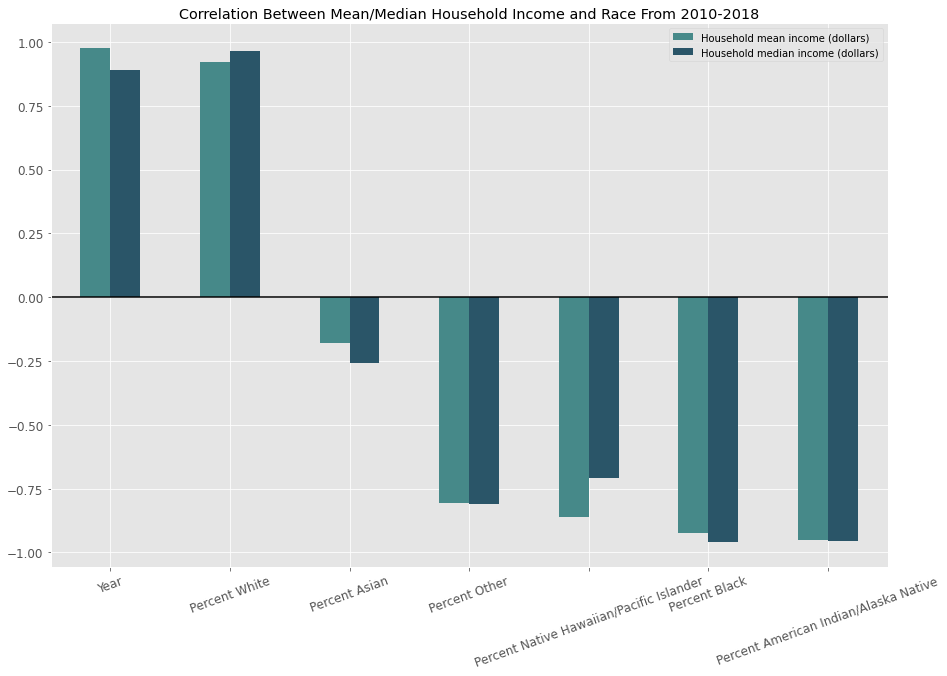

In [84]:
#Converting to census tract data for income correlation

race_forincome = race_pct.copy()
race_forincome = race_forincome.drop('Census Tract', axis=1)

mean_df = cens_income[['Household mean income (dollars)', 'Year']].dropna()
median_df = cens_income[['Household median income (dollars)', 'Year']].dropna()

mean_race = mean_df.merge(race_forincome, on='Year').drop_duplicates()
median_race = median_df.merge(race_forincome, on='Year').drop_duplicates()


pv = mean_race.pivot_table(index='Year', values=(pct_cols+['Household mean income (dollars)']), 
                                                                                   aggfunc=np.mean)
mean_race = pd.DataFrame(pv.to_records())
plotter = mean_race.corr()['Household mean income (dollars)']
plotter.drop('Household mean income (dollars)', inplace=True)

pv2 = median_race.pivot_table(index='Year', values=(pct_cols+['Household median income (dollars)']), 
                                                                                      aggfunc=np.mean)
median_race = pd.DataFrame(pv2.to_records())
plotter2 = median_race.corr()['Household median income (dollars)']
plotter2.drop('Household median income (dollars)', inplace=True)

order = list(plotter.sort_values(ascending=False).index)
plotter = pd.concat([plotter, plotter2], axis=1)
plotter.reindex(order).plot.bar(
                    title='Correlation Between Mean/Median Household Income and Race From 2010-2018', 
                    figsize=(15,10), fontsize='large', rot=20,
    color=['#468989','#2A5568']).axhline(y=0, color='black')

From this graph, we can see that income has a strong positive correlation to the year, due to inflation, and to the percentage of White residents in a census tract. On the other hand, the percentage of minority residents has a negative corrolation with income. This is true for both the median and the mean household income.

## Initial Hypothesis — Visualization

As an initial hypothesis, we believe that the census tracts with the highest initial percentage of Black residents will be most vulnerable to gentrification. Specifically, the census tracts with the highest percentage of Black residents in 2010 would have the largest influx of White residents by 2018. Below, we will run some analysis of our datasets in order to prove our hypothesis.<br><br>
In order to do so, we will first need to separate our datasets into the first year for which we have records, and the last year: 2010 and 2018.

In [85]:
#Make Datasets in 2010 and 2018 to calculate change:
race_in2010 = race_pct[race_pct['Year']==2010]
race_in2018 = race_pct[race_pct['Year']==2018]

race_in2010.set_index('Census Tract', inplace=True)
race_in2018.set_index('Census Tract', inplace=True)

Text(0, 0.5, 'Percentage')

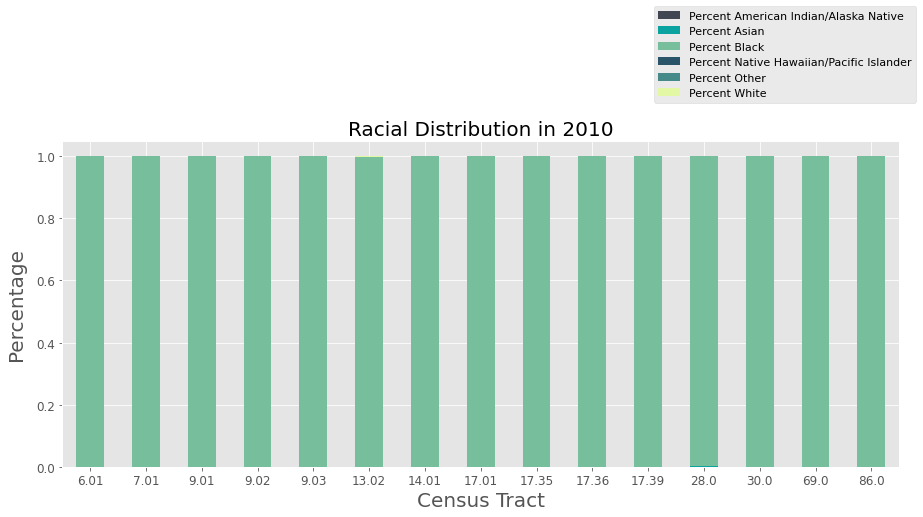

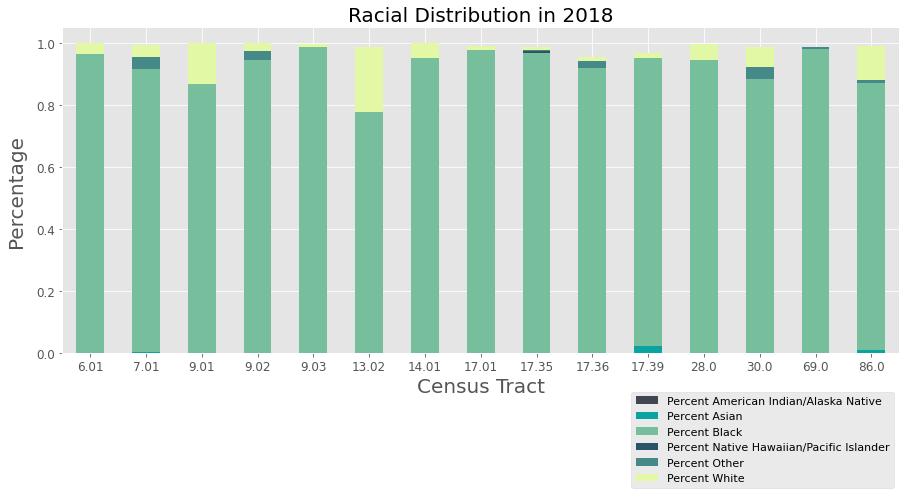

In [86]:
theme = [ '#404753', '#0AA39F','#77be9c',  '#2A5568', '#468989','#E3F8A5']

#Determine which census tracts had the highest pct of Black residents in 2010:
highest_pct_black = cens_race[cens_race['Year']==2010][['Census Tract', 'Percent Black']].sort_values(
                                                            by='Percent Black',ascending=False).head(15)
init_hyp = list(highest_pct_black['Census Tract'].to_dict().values())

#Create subsets for each of the years for comparison
subset_2010 = race_in2010.loc[init_hyp]
subset_2018 = race_in2018.loc[init_hyp]

#-------------------------------------------Plotting--------------------------------------------

#Create pivot tables and plot
ax1 = subset_2010.pivot_table(index='Census Tract', values=pct_cols).plot.bar(stacked=True, color=theme, 
                                    rot=0, figsize=(15,6), fontsize='large')
ax2 = subset_2018.pivot_table(index='Census Tract', values=pct_cols).plot.bar(stacked=True, color=theme, 
                                    fontsize='large', rot=0, figsize=(15,6))

#Format title/axis titles/legend

#ax1
ax1.set_title('Racial Distribution in 2010', fontsize=20)
ax1.legend(bbox_to_anchor=(.7, 1.1), fontsize=11)
ax1.set_xlabel('Census Tract', fontsize=20)
ax1.set_ylabel('Percentage', fontsize=20, labelpad=10)

#ax2
ax2.set_title('Racial Distribution in 2018', fontsize=20)
ax2.legend(bbox_to_anchor=(1, -.1), fontsize=11)
ax2.set_xlabel('Census Tract', fontsize=20)
ax2.set_ylabel('Percentage', fontsize=20, labelpad=10)

## Revised Hypothesis — Visualization
After looking at our initial hypothesis, we realized that the initial conditions we originally selected did not effectively predict the census tracts which would experience the highest positive percent change in White residents. That being said, we decided to modify our hypothesis to look at census tracts with a percentage of Black residents between 40% and 60%, rather than as close to 100% as possible. 

Text(0, 0.5, 'Percentage')

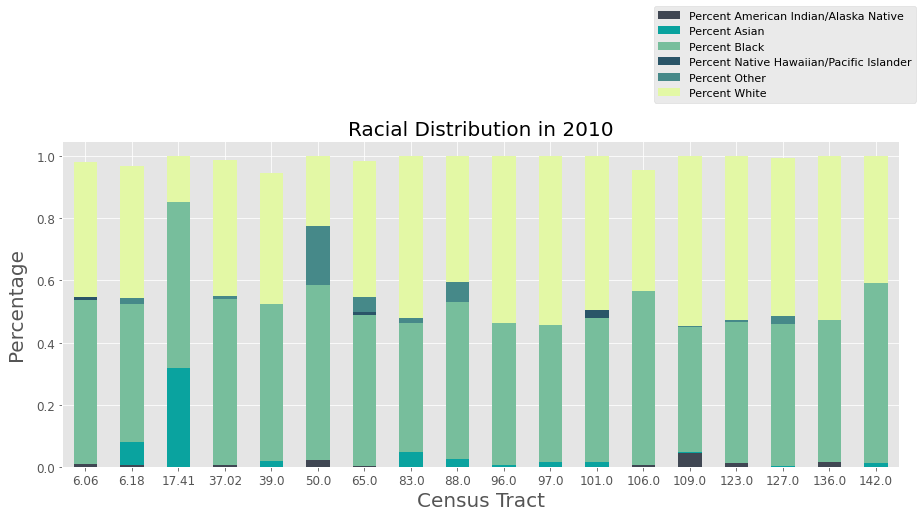

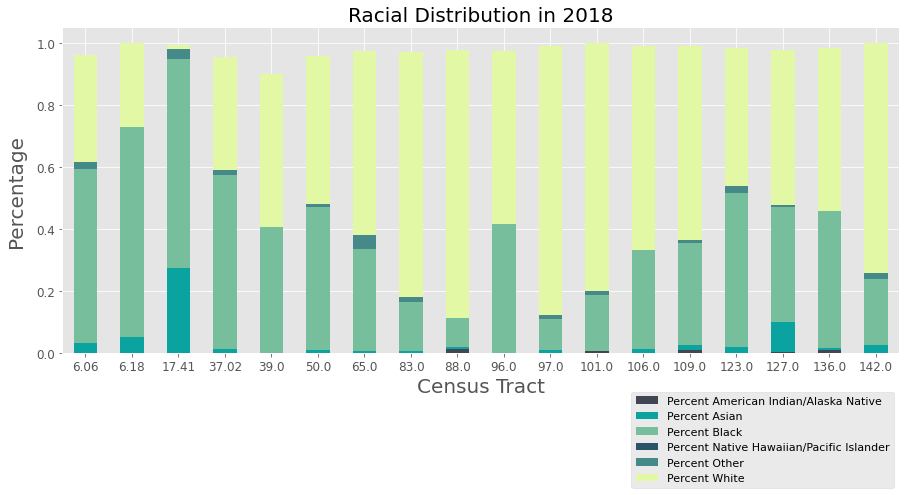

In [87]:
#Need census tract as column value to pull out the data we need, so reset index
race_in2010.reset_index(inplace=True)

#Create new list of census tracts whcih had between 40%-60% Black residents in 2010
rev_hyp = list(race_in2010[(race_in2010['Percent Black']<.6) 
                    & (race_in2010['Percent Black']>.4)]['Census Tract'].to_dict().values())

#Change back index to create subsets
race_in2010.set_index('Census Tract', inplace=True)

#Create subsets for each of the years for comparison
subset_2010 = race_in2010.loc[rev_hyp]
subset_2018 = race_in2018.loc[rev_hyp]

#-------------------------------------------Plotting--------------------------------------------

#Create pivot tables and plot
ax1 = subset_2010.pivot_table(index='Census Tract', values=pct_cols).plot.bar(stacked=True, color=theme, 
                                    rot=0, figsize=(15,6), fontsize='large')
ax2 = subset_2018.pivot_table(index='Census Tract', values=pct_cols).plot.bar(stacked=True, color=theme, 
                                    fontsize='large', rot=0, figsize=(15,6))

#Format title/axis titles/legend

#ax1
ax1.set_title('Racial Distribution in 2010', fontsize=20)
ax1.legend(bbox_to_anchor=(.7, 1.1), fontsize=11)
ax1.set_xlabel('Census Tract', fontsize=20)
ax1.set_ylabel('Percentage', fontsize=20, labelpad=10)

#ax2
ax2.set_title('Racial Distribution in 2018', fontsize=20)
ax2.legend(bbox_to_anchor=(1, -.1), fontsize=11)
ax2.set_xlabel('Census Tract', fontsize=20)
ax2.set_ylabel('Percentage', fontsize=20, labelpad=10)

## Hypothesis Testing — Visualization
In order to validate our hypothesis, we decided to look at the Census Tracts which experienced the largest positive change in white residents from 2010-2018. 

Text(0, 0.5, 'Percentage')

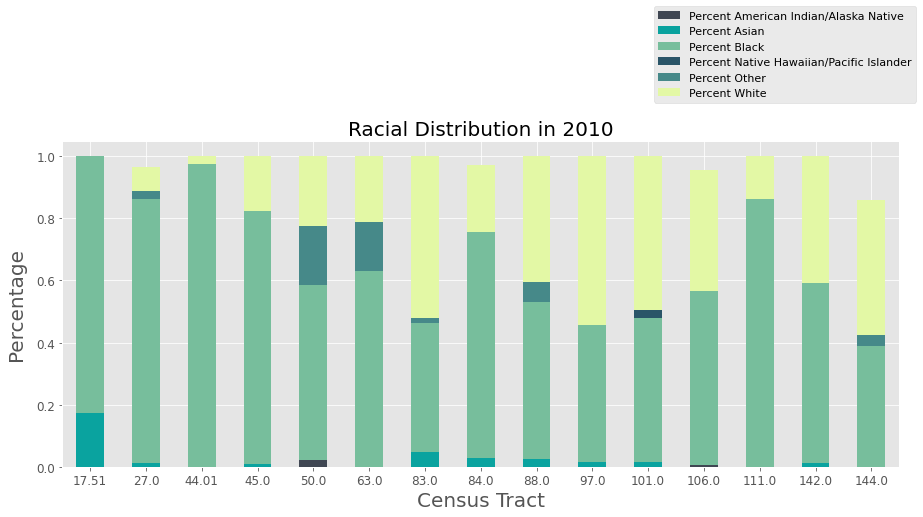

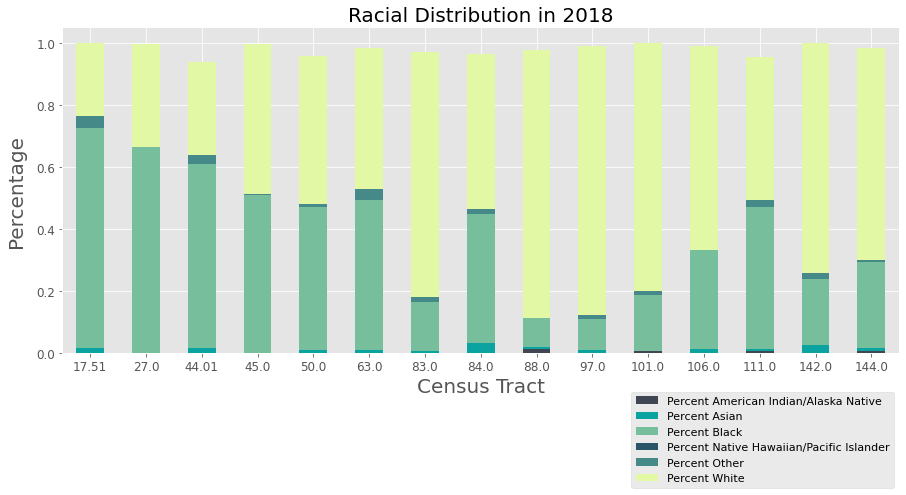

In [88]:
#Calculate which neighborhoods had the biggest influx of white people between the two time periods:
change_white = race_pct[['Census Tract']].drop_duplicates()
change_white.set_index('Census Tract', inplace=True)

#Subtract most recent data from old data
change_white['Change in White'] = race_in2018['Percent White'] - race_in2010['Percent White']

#Save the 15 census tracts with the highest increase in population of white people
highest_change = list(
    change_white['Change in White'].sort_values(ascending=False).head(15).astype(str).to_dict().keys())

#Create subsets for each of the years for comparison
subset_2010 = race_in2010.loc[highest_change]
subset_2018 = race_in2018.loc[highest_change]

#-------------------------------------------Plotting--------------------------------------------

#Create pivot tables and plot
ax1 = subset_2010.pivot_table(index='Census Tract', values=pct_cols).plot.bar(stacked=True, color=theme, 
                                    rot=0, figsize=(15,6), fontsize='large')
ax2 = subset_2018.pivot_table(index='Census Tract', values=pct_cols).plot.bar(stacked=True, color=theme, 
                                    fontsize='large', rot=0, figsize=(15,6))

#Format title/axis titles/legend

#ax1
ax1.set_title('Racial Distribution in 2010', fontsize=20)
ax1.legend(bbox_to_anchor=(.7, 1.1), fontsize=11)
ax1.set_xlabel('Census Tract', fontsize=20)
ax1.set_ylabel('Percentage', fontsize=20, labelpad=10)

#ax2
ax2.set_title('Racial Distribution in 2018', fontsize=20)
ax2.legend(bbox_to_anchor=(1, -.1), fontsize=11)
ax2.set_xlabel('Census Tract', fontsize=20)
ax2.set_ylabel('Percentage', fontsize=20, labelpad=10)

This graph should look very similar to the one for our revised hypothesis. The reason for this is that 7 of the census tracts from our revised hypothesis turned out to be in the top 15 of those expereincing the largest influx of White residents.

Text(0, 0.5, 'Change in Percentage of White Residents between 2010-2018')

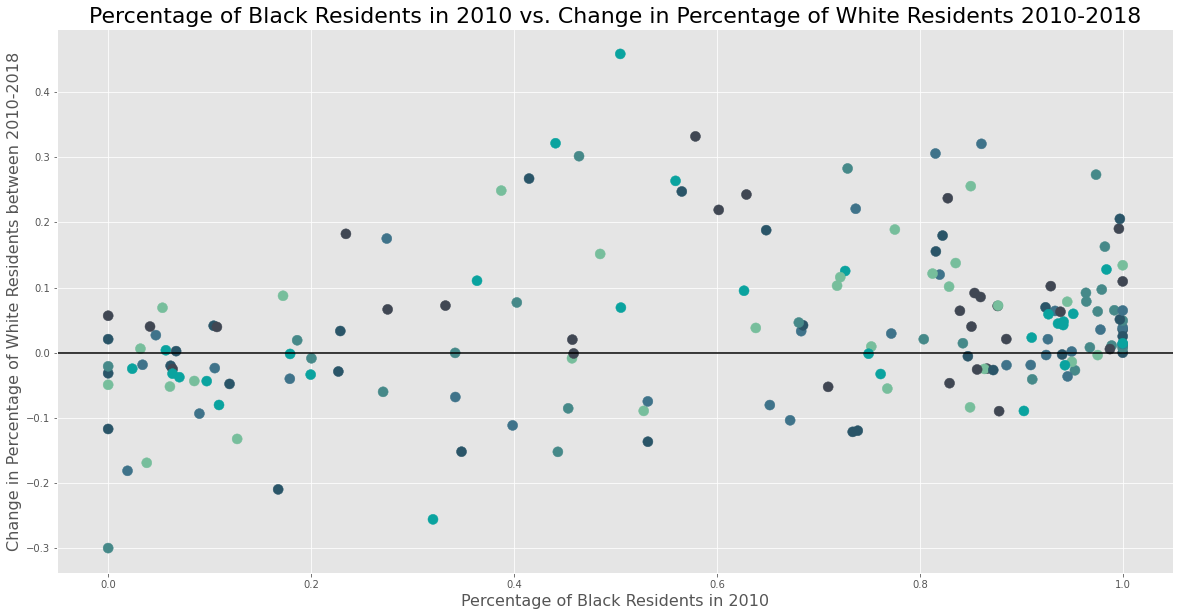

In [89]:
#SCATTERPLOT
colors = ['#3F738A', '#404753', '#0AA39F','#77be9c',  '#2A5568', '#468989']
change_white['Percent Black 2010'] = race_in2010['Percent Black']
change_white.plot.scatter(x='Percent Black 2010', y='Change in White', figsize=(20,10), c=colors*29,
                               s=100).axhline(y=0, color='black')
plt.title('Percentage of Black Residents in 2010 vs. Change in Percentage of White Residents 2010-2018',
         fontsize=22)
plt.xlabel('Percentage of Black Residents in 2010', fontsize=16)
plt.ylabel('Change in Percentage of White Residents between 2010-2018', fontsize=16)

In order to further test our hypothesis, we decided to plot all of the starting percentages of Black residents in 2010 against the change in Percentage of White Residents between 2010-2018. The range of our hypothesis falls between 40-60% on the x-axis, which, looking at the data, is a pretty accurate range.

We will now show a geographical representation of our findings. Using the census tract geometric data, we will show how the census tracts in New Orleans changed between 2010 and 2018.

In [90]:
geo_df = gpd.read_file('./Data/tract_nola.geojson')
race_df = pd.read_csv("./Data/cleaned_race_data.csv")
latLong_df = pd.read_csv('./Data/CensusTractToLatLong.csv')

In [91]:
# create Percent White column
race_df["Percent White"] = race_df["White"] / race_df["Total Population"]
race_df["Percent Black"] = race_df["Black"] / race_df["Total Population"]
# merge race data with lat/long data
race_df = race_df.merge(latLong_df, how="left", left_on="Geo_ID", right_on="GEOID")

In [92]:
# get data from beginning and end of dataset
race_df_2010 = race_df.loc[race_df["Year"] == 2010]
race_df_2018 = race_df.loc[race_df["Year"] == 2018]

race_df_2010.set_index("Geo_ID", inplace=True)
race_df_2018.set_index("Geo_ID", inplace=True)

# calculate change in percentage of white residents for each census tract
change_white = race_df_2018["Percent White"] - race_df_2010["Percent White"]

In [93]:
# add race data to lat/long df
latLong_df = latLong_df.merge(change_white, how="inner", left_on="GEOID", right_on="Geo_ID")
# update name
latLong_df.rename(columns={"Percent White" : "Change in Percent White"}, inplace=True)

In [94]:
m = fl.Map(
    location = [29.9511, -90.0715],
    zoom_start = 10,
    tiles="Stamen Toner")

In [95]:
fl.Choropleth(
    geo_data="./Data/tract_nola.geojson",
    name="Change in Percent White from 2010 to 2018 by Census Tract",
    data=latLong_df,
    columns=["GEOID", "Change in Percent White"],
    key_on='feature.properties.GEOID', 
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Change in Percent White from 2010 to 2018 by Census Tract"
    ).add_to(m)

In [96]:
# create markers
race_df_2010_markers = race_df_2010.loc[(race_df_2010["Percent Black"] < 0.6) & (race_df_2010["Percent Black"] > 0.4)]

In [97]:
# add markers to map
race_df_2010_markers.apply(lambda x: fl.Circle([x["CENTLAT"], x["CENTLON"]], radius=10).add_to(m), axis=1)

Geo_ID
22071006500    <folium.vector_layers.Circle object at 0x00000...
22071008300    <folium.vector_layers.Circle object at 0x00000...
22071008800    <folium.vector_layers.Circle object at 0x00000...
22071009600    <folium.vector_layers.Circle object at 0x00000...
22071009700    <folium.vector_layers.Circle object at 0x00000...
22071010100    <folium.vector_layers.Circle object at 0x00000...
22071010600    <folium.vector_layers.Circle object at 0x00000...
22071010900    <folium.vector_layers.Circle object at 0x00000...
22071012300    <folium.vector_layers.Circle object at 0x00000...
22071012700    <folium.vector_layers.Circle object at 0x00000...
22071013600    <folium.vector_layers.Circle object at 0x00000...
22071014200    <folium.vector_layers.Circle object at 0x00000...
22071000606    <folium.vector_layers.Circle object at 0x00000...
22071000618    <folium.vector_layers.Circle object at 0x00000...
22071001741    <folium.vector_layers.Circle object at 0x00000...
22071003702    <fo

In [98]:
m

This map shows the change in percent white residents between 2010 and 2018 by census tract. The more green the tract, the higher the influx of white residents. The blue markers mark tracts which we predicted would be vulnerable based on their initial percentage of black residents.

Gentrification frequently leads to increased levels of income inequality. This can be seen in our dataset by seeing how the mean income to median income ratio, which is a proxy for skewness, changes each year. 

In [99]:
income_data = pd.read_csv('./Data/cleaned_income_data.csv')

In [100]:
# calculate ratio of mean income to median income
income_data["Mean Income / Median Income"] = income_data["Household mean income (dollars)"] / income_data["Household median income (dollars)"]

In [101]:
# find identified tracts with positive change in white residents
race_df_2010_markers = race_df_2010_markers.merge(latLong_df, how="inner", on="GEOID")
race_df_2010_markers = race_df_2010_markers.loc[race_df_2010_markers["Change in Percent White"] > 0]


In [102]:
# add mean income / median income data
income_data = income_data.merge(race_df_2010_markers, how='right', left_on="Geo_ID", right_on="GEOID")

Text(0.5, 1.0, 'Mean Income / Median Income for each census tract 2010-2018')

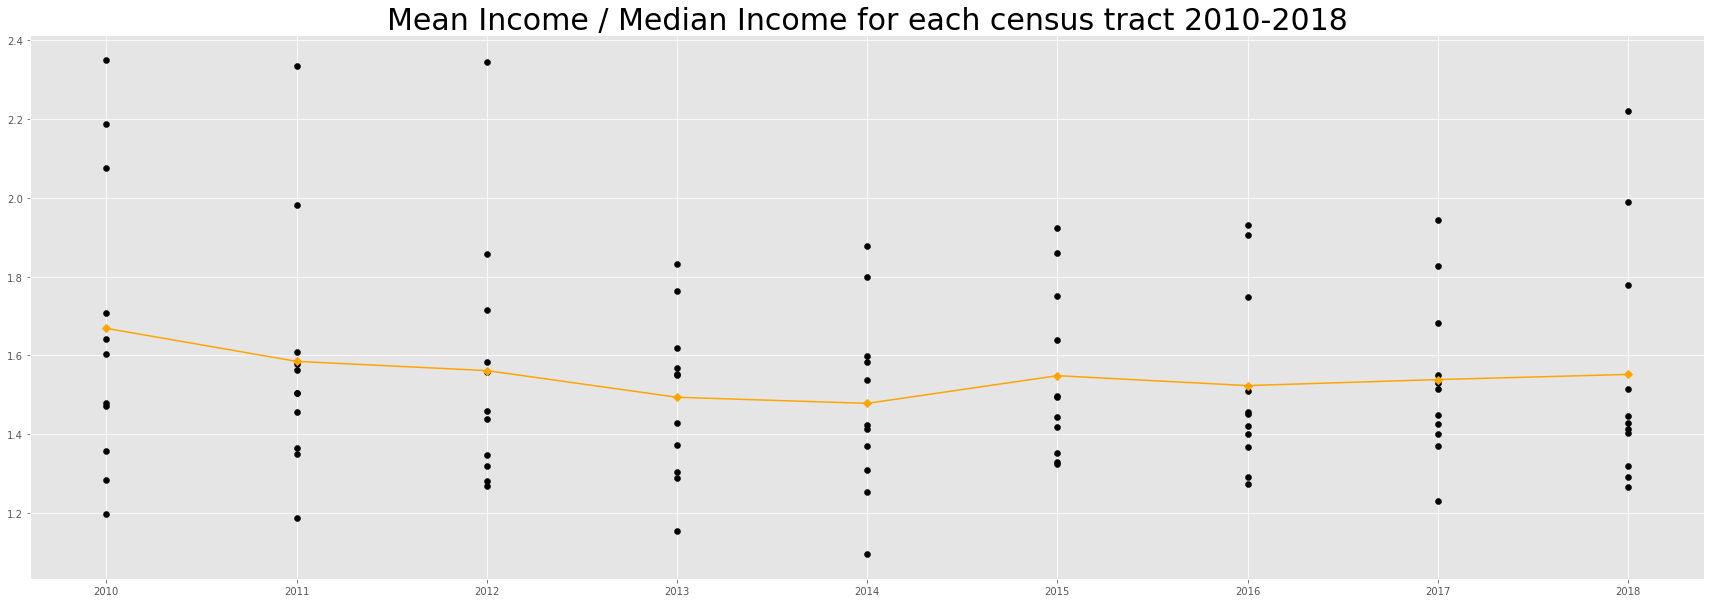

In [103]:
fig, ax = plt.subplots(figsize = (30,10))
year = np.linspace(2010, 2018, 9)

for GEOID in income_data["GEOID"].unique():
    ax.scatter(year, income_data.loc[income_data["GEOID"] == GEOID]["Mean Income / Median Income"], color = "black")


ax.plot(year, income_data[["Mean Income / Median Income", "Year_x"]].groupby(["Year_x"]).mean(), marker = "D", color="orange", label = "Average")
ax.set_title("Mean Income / Median Income for each census tract 2010-2018", fontsize=30)

Unfortunately, this graph did not show us what we'd hoped. The skewness of the data, according to the Mean / Median, seems to actually go down during this time period. 

### Looking at the Change in Mean/Median Household Income for Census Tracts in our Revised Hypothesis

Text(0.5, 1.0, 'Comparison of Mean Income in 2010 and 2018 for Census Tracts in our Revised Hypothesis')

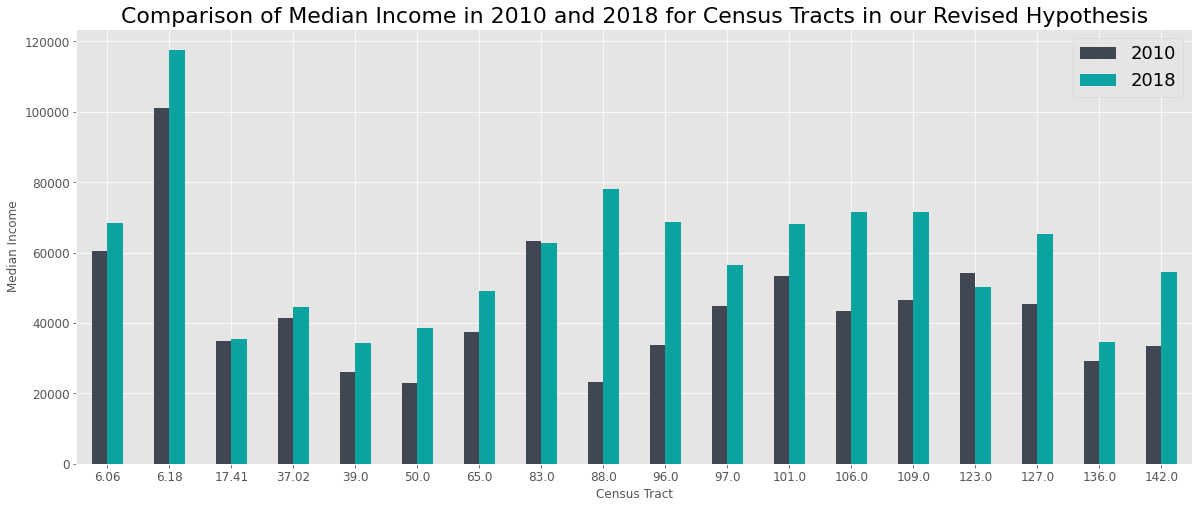

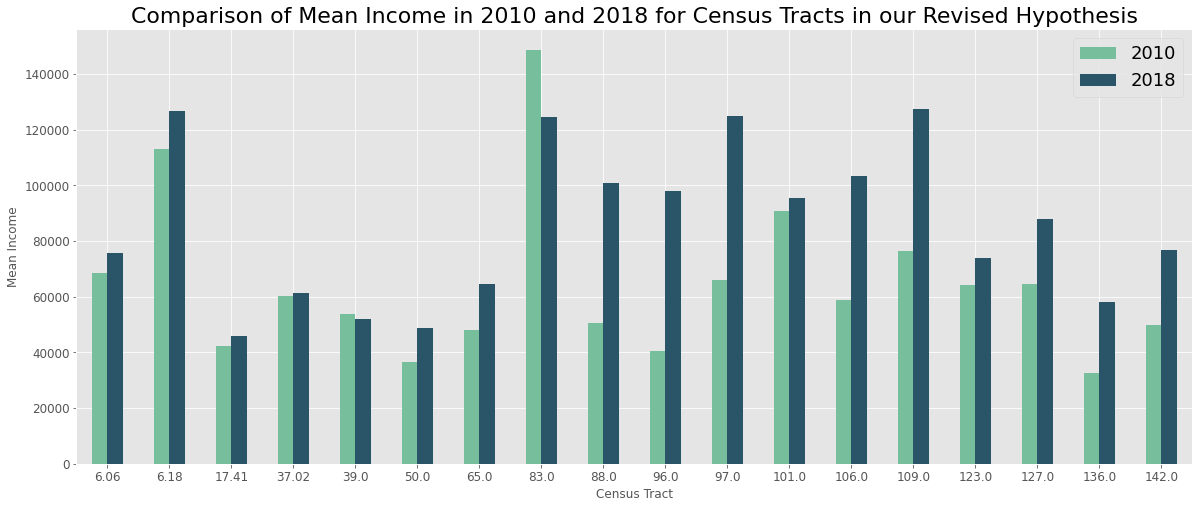

In [104]:
#Want to look at revised hypothesis census tracts and how median/mean income changed 2010-2018
revised_hyp = cens_income[['Census Tract','Household median income (dollars)', 
                           'Household mean income (dollars)', 'Year']]
#Set index to be able to call .loc
revised_hyp = revised_hyp.set_index('Census Tract')

#Only select Census Tracts in our hypothesis
revised_hyp = revised_hyp.loc[rev_hyp]

#Specifying only two years of data: 2010, 2018
inc_change = revised_hyp[(revised_hyp.Year==2010) | (revised_hyp.Year==2018)]

#Change index back
inc_change.reset_index(inplace=True)

#-------------------------------------------Plotting--------------------------------------------

#set theme
temp = theme

ax1 = inc_change.pivot_table(index='Census Tract', 
                       columns='Year', values='Household median income (dollars)'
                    ).plot.bar(figsize=(20,8), color=temp[:2], rot=0, fontsize='large')

ax2 = inc_change.pivot_table(index='Census Tract', 
                       columns='Year', values='Household mean income (dollars)'
                   ).plot.bar(figsize=(20,8), color=temp[2:4], rot=0, fontsize='large')

#Setting labels and titles
ax1.legend(fontsize=18)
ax1.set_ylabel('Median Income')
ax1.set_title('Comparison of Median Income in 2010 and 2018 for Census Tracts in our Revised Hypothesis', 
                                                                                          fontsize=22)
ax2.legend(fontsize=18)
ax2.set_ylabel('Mean Income')
ax2.set_title('Comparison of Mean Income in 2010 and 2018 for Census Tracts in our Revised Hypothesis', 
                                                                                          fontsize=22)


Both mean and median housheold income increased significantly from 2010-2018 in the Census Tracts defined by our revised hypothesis.

# Looking into Another Dataset
**Source:** The Data Center analysis of data from U.S. Census 2000 Summary File 1 (SF1) and 2014-2018 American Community Survey. These data tables support Neighborhood Statistical Area Data Profiles. This includes 252 data points for all 72 neighborhood statistical areas, with New Orleans and United States comparisons. Data originates from Census 2000 and 2010, American Community Survey 2014–2018, and 2017 Local Employment Dynamics data — including housing and housing costs, income and poverty, transportation, educational attainment, language, employment, and more.

## Loading in and Cleaning the Data
My analysis utilizes a combination of three different datasets:<br><br>
`race_df`: The distribution of racial makeup for each neighborhood spanning 2000 and 2014-2018<br>
`avg_income_df`: Average household income for each neighborhood spanning 2000 and 2014-2018<br>
`avg_rent_df`: Average contract and gross rent (gross rent includes utilities) for each neighborhood in 2014-2018 only<br><br>
By combining these datasets, we can visualize the way that racial makeup plays into average household income and average rent prices.

In [105]:
#Loading in another dataset
xls = pd.ExcelFile("./Data/Neighborhood profiles data tables.xlsx")

#import and clean racial distribution dataset
race_df = pd.read_excel(xls, "Table 4", skiprows = 11)
race_df.drop(columns = ["Unnamed: 4", "Unnamed: 8", "Unnamed: 12", "Unnamed: 16", "Unnamed: 20", 
                        "Unnamed: 24", "MOE", "MOE.1", "MOE.2", "MOE.3", "MOE.4", "MOE.5", "MOE.6", 
                        "2000.4", "2014-2018.4"], inplace=True)
race_df.rename(columns = { 
    "Unnamed: 0" : "Neighborhood",
    2000 : "Percent Black in 2000", 
    "2014-2018" : "Percent Black in 2014-2018",
    "2000.1" : "Percent White in 2000", 
    "2014-2018.1" : "Percent White in 2014-2018",
    "2000.2" : "Percent Asian in 2000", 
    "2014-2018.2" : "Percent Asian in 2014-2018",
    "2000.3" : "Percent American Indian in 2000", 
    "2014-2018.3" : "Percent American Indian in 2014-2018",
    "2000.5" : "Percent Hispanic in 2000", 
    "2013-2017" : "Percent Hispanic in 2013-2017",
    "2000.6" : "Percent Other in 2000", 
    "2013-2017.1" : "Percent Other in 2013-2017"
    }, inplace = True)

race_df = race_df.replace('NaN%', 0)
race_df.dropna(inplace=True)
race_df["Percent Black in 2014-2018"] = race_df["Percent Black in 2014-2018"].astype(float)
race_df["Percent White in 2014-2018"] = race_df["Percent White in 2014-2018"].astype(float)
race_df["Percent Asian in 2014-2018"] = race_df["Percent Asian in 2014-2018"].astype(float)
race_df["Percent American Indian in 2014-2018"] = \
                        race_df["Percent American Indian in 2014-2018"].astype(float)
race_df["Percent Hispanic in 2013-2017"] = race_df["Percent Hispanic in 2013-2017"].astype(float)
race_df["Percent Other in 2013-2017"] = race_df["Percent Other in 2013-2017"].astype(float)

#Import and clean average household income data
avg_income_df = pd.read_excel(xls, "Table 14", skiprows = 11)
avg_income_df.drop(columns='MOE', inplace=True)
avg_income_df.rename(columns = {'Unnamed: 0':'Neighborhood', 2000 : "Avg Household Income in 2000", 
    "2014-2018" : "Avg Household Income in 2014-2018"}, inplace=True)

#Cleaning average rent data
avg_rent_df = pd.read_excel(xls, "Table 11", skiprows = 11)
avg_rent_df.drop(columns = ["Unnamed: 3","MOE", "MOE.1"], inplace=True)
avg_rent_df.rename(columns = { 
    "Unnamed: 0" : "Neighborhood",
    "2014-2018" : "Avg Contract Rent in 2014-2018",
    "2014-2018.1" : "Avg Gross Rent in 2014-2018"
    }, inplace = True)

This visualization simply demonstrates how drastically the shift in demographic was moving from 2000 to 2018 in this sample set of New Orleans neighborhoods. These large demographic changes in only a span of a few years are likely due to gentrification in New Orleans. We can utilize these results along with other neighborhood information to determine the areas experiencing the most impact.

# Exploratory Analysis on our Second Dataset
### Comparing Correlation Between Average Household Income and Race in 2000 and 2014-2018
For this visualization, I decided to compare the correlation between the racial makeup of each neighborhood in the dataset and its average household income. <br>
To do so, I merged the dataset of racial makeup with that of average income and found the correlation. I then filtered out all of the columns for each respective year and created two datasets: `race_income_2000` and `race_income_2018` which each contain the relationship between the two variables for that year only. Finally, I plotted it so that the positive and negative correlations are clear.

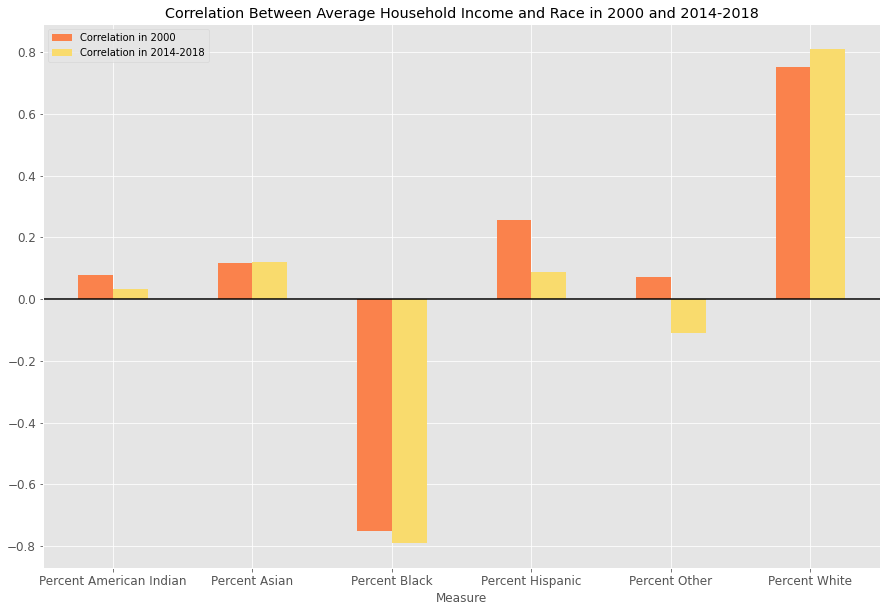

In [106]:
#Create dataframe comparing race and income
race_income = avg_income_df.merge(race_df, how='outer', on='Neighborhood')

#Create new column names for ease:
new_cols = ['Percent Black', 'Percent White', 'Percent Asian', 'Percent American Indian', 
        'Percent Hispanic', 'Percent Other']

#filter out datasets into 2000 and 2014-2018
race_income_2000 = race_df.filter(regex='2000$',axis=1)
race_income_2000.columns = new_cols
race_income_2000['Neighborhood'] = race_df['Neighborhood']
race_income_2000['Year'] = '2000'
race_income_2000['Avg Household Income'] = race_income['Avg Household Income in 2000']

race_income_2018 = race_df.filter(regex='201.$',axis=1)
race_income_2018.columns = new_cols
race_income_2018['Neighborhood'] = race_df['Neighborhood']
race_income_2018['Year'] = '2014-2018'
race_income_2018['Avg Household Income'] = race_income['Avg Household Income in 2014-2018'].replace(
                                                                                '$NaN', np.nan).dropna()

#correlation dataset for 2000 and 2014-2018
corr_2000 = pd.DataFrame(race_income_2000.corr()['Avg Household Income']).reset_index()
corr_2018 = pd.DataFrame(race_income_2018.corr()['Avg Household Income']).reset_index()

#Merge the two datasets, adding a suffix for the year
corr_by_year = corr_2000.merge(corr_2018, how='outer', on='index', suffixes=('_2000', '_2014-2018'))

#Make column names more readable and drop Avg Household Inc's comparison with itself which is always 1
corr_by_year.columns = ['Measure', 'Correlation in 2000', 'Correlation in 2014-2018']
corr_by_year.drop(6, inplace=True)

#Plot the pivot table with the appropriate Labels
corr_by_year.pivot_table(index='Measure', 
                    values = ['Correlation in 2000', 'Correlation in 2014-2018']).plot.bar(
                    title='Correlation Between Average Household Income and Race in 2000 and 2014-2018', 
                    figsize=(15,10), fontsize='large', rot=0, color=['#fa824c', '#f9db6d']).axhline(y=0, 
                                                                                        color='black')

From this graph it is very clear to see that the percentage of black residents has a very strong negative correlation with average household income. The opposite is true for white residents. I found it interesting that the general trend when moving from 2000 to 2014-2018, the prevalence of races other than white had a more negative correlation with average household income.

### Visualizing the Correlation Between Average Contract Rent and Race in 2014-2018
Similar to the previous graph, I wanted to illustrate how race is correlated with rent prices. <br>
To do so, I followed a similar process by merging the dataset of racial makeup with that of average contract rent (excluding utilities) and found the correlation. Since the dataset only has rent prices for 2014-2018, I focused on a simple correlation graph rather than a comparison. Finally, I plotted it such that the positive and negative correlations are clear.

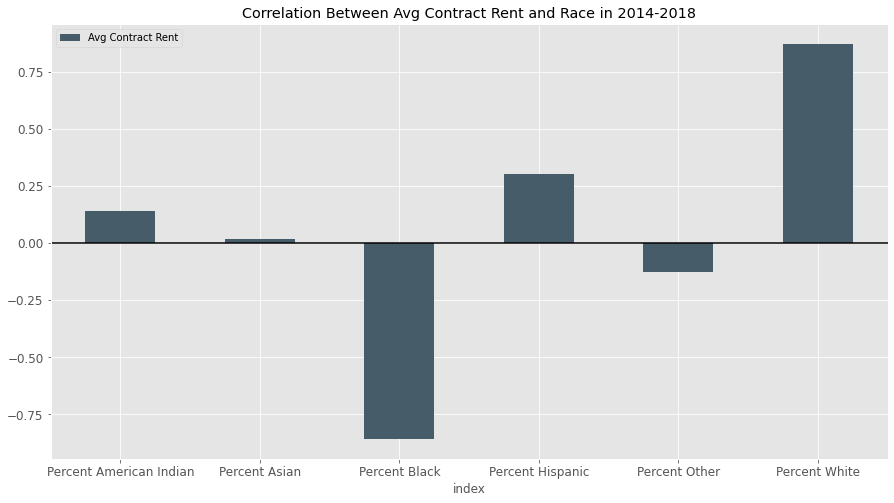

In [107]:
#Create dataframe comparing race and rent
race_rent = avg_rent_df.merge(race_df, how='outer', on='Neighborhood')

race_rent_2018 = race_df.filter(regex='201.$',axis=1)
race_rent_2018.columns = new_cols
race_rent_2018['Neighborhood'] = race_df['Neighborhood']
race_rent_2018['Year'] = '2014-2018'
race_rent_2018['Avg Contract Rent'] = race_rent['Avg Contract Rent in 2014-2018'].replace(
                                                                    'na', np.nan).dropna().astype(float)

#correlation dataset for 2000 and 2014-2018
corr_2018 = pd.DataFrame(race_rent_2018.corr()['Avg Contract Rent']).reset_index()


#Make column names more readable and drop Avg Household Inc's comparison with itself which is always 1
corr_2018.drop(6, inplace=True)

#Plot the pivot table with the appropriate Labels
corr_2018.pivot_table(index='index', 
                    values = ['Avg Contract Rent']).plot.bar(
                    title='Correlation Between Avg Contract Rent and Race in 2014-2018', 
                    figsize=(15,8), fontsize='large', rot=0, color='#465c69').axhline(y=0, 
                                                                                        color='black')

From this graph it is very clear to see that the percentage of black residents has a very strong negative correlation with average rent price. The opposite is true for white residents. This is consistent with the effects of gentrification: the larger the influx of white residents into a given area, the more expensive the rent becomes.

### Comparing Average Income in 2000 vs 2014-2018
For this visualization, I simply made a boxplot showing Average Household Income in 2000 vs Average Household Income in 2014-2018 to more easily represent summary statistics for this variable.

Text(0.5, 1.0, 'Analysis of Average Household Income in 2014-2018')

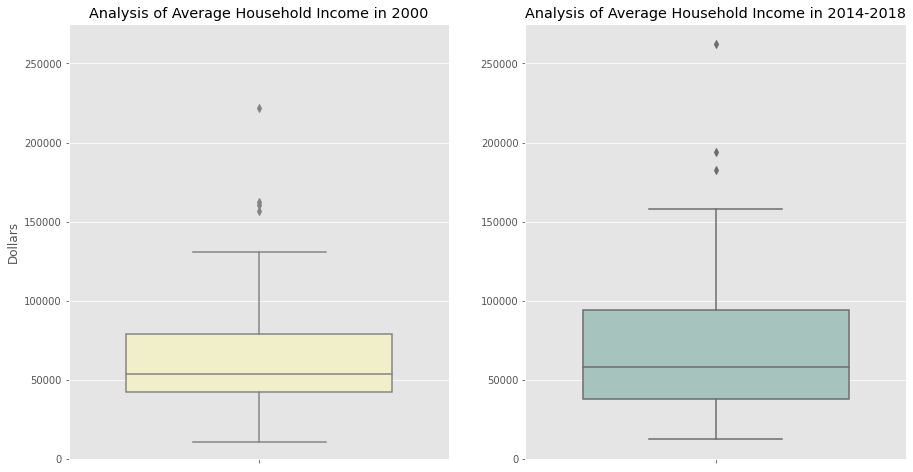

In [108]:
#Create two boxplots showing summary statistics

#Year 2000
plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
p1 = sns.boxplot(data = race_income_2000, color='#f6f5c2', y = 'Avg Household Income', width=.7)
p1.set_ylim(0, 275000)
p1.set_ylabel("Dollars")
p1.set_title("Analysis of Average Household Income in 2000")

#Years 2014-2018
plt.subplot(1, 2, 2)
p2 = sns.boxplot(data = race_income_2018, color='#a1c8c1', y = 'Avg Household Income', width=.7)
p2.set_ylim(0, 275000)
p2.set_ylabel("")
p2.set_title("Analysis of Average Household Income in 2014-2018")

These two plots show that the median increased from 2000 to 2014-2018, and both the min and max expereinced an upward shift. The height of the box increased as well. Specifications on the statistics plotted here are made below.

# Summary Statistics and Measures of Central Tendency
In order to summarize the dataset I've been working with, I created a table of summary statistics incorporating the describe() function along with the median, the variance, the interquartile range (IQR), and the mean absolute deviation (MAD) for each year.

In [109]:
#Add row of median, variance, IQR, and Mean Absolute Deviation to 2000 data and 2014-2018 data 

#save summary stats
stats_2000 = race_income_2000.describe()
stats_2018 = race_income_2018.describe()

#create dataframes
more2000 = pd.DataFrame(columns=['index'] + stats_2000.columns.tolist())
more2018 = pd.DataFrame(columns=['index'] + stats_2018.columns.tolist())

#start lists with decription of stats
IQR2000, IQR2018 = ['IQR'], ['IQR']
var2000, var2018 = ['var'], ['var']
med2000, med2018 = ['median'], ['median']
mad2000, mad2018 = ['MAD'], ['MAD']


#add stats to each respective list
for c in stats_2018.columns:
    IQR2000.append(race_income_2000[c].quantile(.75) - race_income_2000[c].quantile(.25))
    IQR2018.append(race_income_2018[c].quantile(.75) - race_income_2018[c].quantile(.25))
    var2000.append(race_income_2000[c].var())
    var2018.append(race_income_2018[c].var())
    med2000.append(race_income_2000[c].median())
    med2018.append(race_income_2018[c].median())
    mad2000.append(race_income_2000[c].mad())
    mad2018.append(race_income_2018[c].mad())
    
    
#add lists to dfs
more2000.loc[0], more2018.loc[0] = med2000, med2018
more2000.loc[1], more2018.loc[1] = var2000, var2018
more2000.loc[2], more2018.loc[2] = IQR2000, IQR2018
more2000.loc[3], more2018.loc[3] = mad2000, mad2018

#add dfs back in
stats_2000 = pd.concat([stats_2000.reset_index(), more2000]).set_index('index')
stats_2018 = pd.concat([stats_2018.reset_index(), more2018]).set_index('index')

#display data for 2000
stats_2000

,Percent Black,Percent White,Percent Asian,Percent American Indian,Percent Hispanic,Percent Other,Avg Household Income
index,,,,,,,
count,74.0000,74.0000,74.0000,74.0000,74.0000,74.0000,74.0000
mean,0.6119,0.3243,0.0189,0.0019,0.0311,0.0021,62873.6216
std,0.3293,0.3123,0.0460,0.0015,0.0211,0.0019,35687.4230
min,0.0060,0.0020,0.0000,0.0000,0.0010,0.0000,10472.0000
25%,0.3323,0.0540,0.0023,0.0010,0.0150,0.0010,42327.0000
50%,0.6880,0.2240,0.0070,0.0020,0.0265,0.0020,53822.0000
75%,0.9005,0.5757,0.0160,0.0030,0.0420,0.0030,78663.7500
max,0.9910,0.9430,0.3710,0.0070,0.1250,0.0080,221533.0000
median,0.6880,0.2240,0.0070,0.0020,0.0265,0.0020,53822.0000


In [110]:
#display data for 2014-2018
stats_2018

,Percent Black,Percent White,Percent Asian,Percent American Indian,Percent Hispanic,Percent Other,Avg Household Income
index,,,,,,,
count,74.0000,74.0000,74.0000,74.0000,74.0000,74.0000,73.0000
mean,0.5406,0.3505,0.0228,0.0013,0.0519,0.0047,71214.6027
std,0.3357,0.3104,0.0467,0.0026,0.0371,0.0074,44819.4959
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,12324.0000
25%,0.1927,0.0762,0.0030,0.0000,0.0238,0.0000,37697.0000
50%,0.5965,0.2235,0.0115,0.0000,0.0470,0.0020,57960.0000
75%,0.8207,0.6442,0.0238,0.0018,0.0755,0.0058,93979.0000
max,0.9830,0.9590,0.3640,0.0150,0.1780,0.0400,262051.0000
median,0.5965,0.2235,0.0115,0.0000,0.0470,0.0020,57960.0000


From comparing the two tables, the data is pretty similar for the most part, however the average racial distribution of white residents has increased, ultimately shrinking that of black residents.

### Comparing Racial Distributions in 2000 vs 2014-2018
For this visualization, I decided to compare the racial makeup of 10 neighborhoods in New Orleans using the data from 2000 and from 2014-2018. I chose the 10 neighborhoods by calculating those in which neighborhoods which experienced the largest increase in percentage of white residents between the two time periods. <br>
To do so, I created two separate dataframes for the different time periods and concatenated them into a dataframe called race_by_year, and calculated the change in percentage of white inhabitants between the two datapoints, sorting them descendingly and saving the indices. 

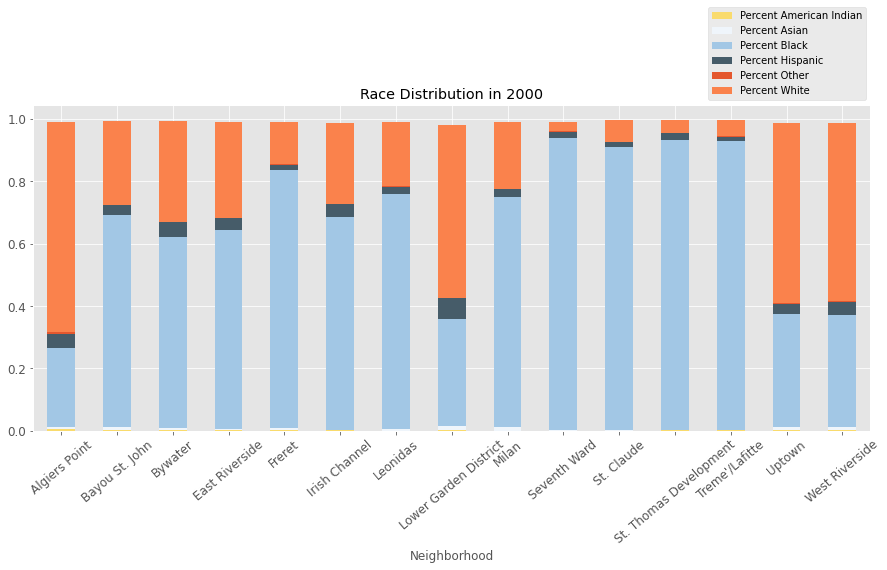

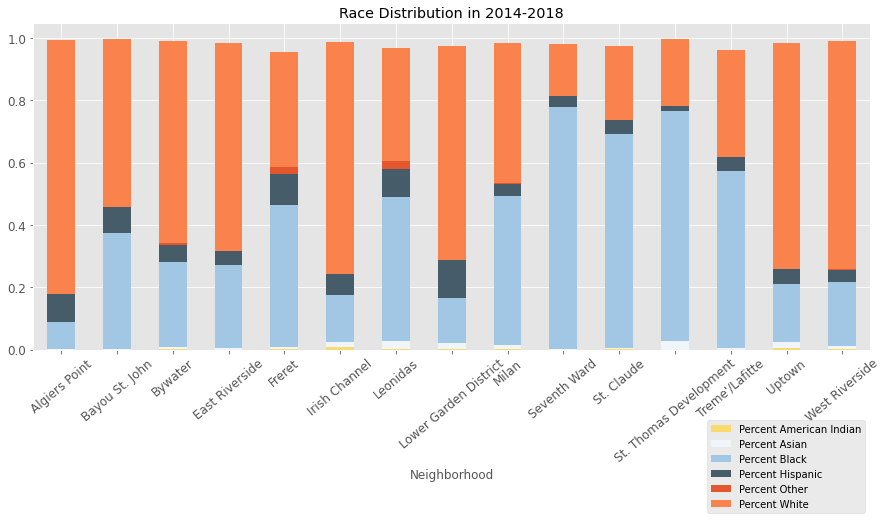

In [111]:
#Extract all column names ending in "2000"
race_in2000 = race_df.filter(regex='2000$',axis=1)
race_in2000.columns = new_cols
race_in2000['Neighborhood'] = race_df['Neighborhood']
race_in2000['Year'] = '2000'


#Extract all column names ending in "201_"
race_in2018 = race_df.filter(regex='201.$',axis=1)
race_in2018.columns = new_cols
race_in2018['Neighborhood'] = race_df['Neighborhood']
race_in2018['Year'] = '2014-2018'

#combine the two dfs
race_by_year = pd.concat([race_in2000, race_in2018])


#Calculate which neighborhoods had the biggest influx of white people between the two time periods:

#Subtract most recent data from old data
race_by_year['Change in White'] = race_in2018['Percent White'] - race_in2000['Percent White']

#Sort values ascendingly and save indexes of the first 15 values
# **Note: head is set to 30 because there are duplicate values and we want 15
idxs = list(race_by_year['Change in White'].sort_values(ascending=False).head(30).to_dict().keys())

#Save the 10 neighborhoods with the highest increase in population of white people
highest_change = race_by_year.iloc[idxs]['Neighborhood'].tolist()

order = ['Percent White', 'Percent Black', 'Percent Hispanic', 'Percent Asian', 
         'Percent American Indian', 'Percent Other']

#Create subsets for each of the years for comparison
subset_2000 = race_in2000[race_df.Neighborhood.isin(highest_change)].sort_values(by='Percent White')
subset_2018 = race_in2018[race_df.Neighborhood.isin(highest_change)].sort_values(by='Percent White')

#-------------------------------------------Plotting--------------------------------------------

#color theme for graphs -- using a different theme to distinguish between datasets
theme2 = ['#f9db6d', '#eff5fb', '#a2c7e5', '#465c69', '#e4572e', '#fa824c']

#Create pivot tables and plot
subset_2000.pivot_table(index='Neighborhood', values=order).plot.bar(stacked=True, fontsize='large',
                            rot=40, figsize=(15,6), color=theme2, title='Race Distribution in 2000'
                                        ).legend(bbox_to_anchor=(.8, 1))
subset_2018.pivot_table(index='Neighborhood', values=order).plot.bar(stacked=True, fontsize='large',
                        rot=40, figsize=(15,6), color=theme2, title='Race Distribution in 2014-2018'
                                        ).legend(bbox_to_anchor=(1, -.2))



## How Did Factors Like Average Household Income Change for These Neighborhoods between the Two Time Periods?
Before, we concluded from the data that there is a strong positive correlation between both average rent price and average household income with the percentage of White residents, while the opposite is true for the percentage of Black residents. Since we only have average rent data for 2014-2018, let's see how the mean income in these specific neighborhoods changed from 2000 - 2018.

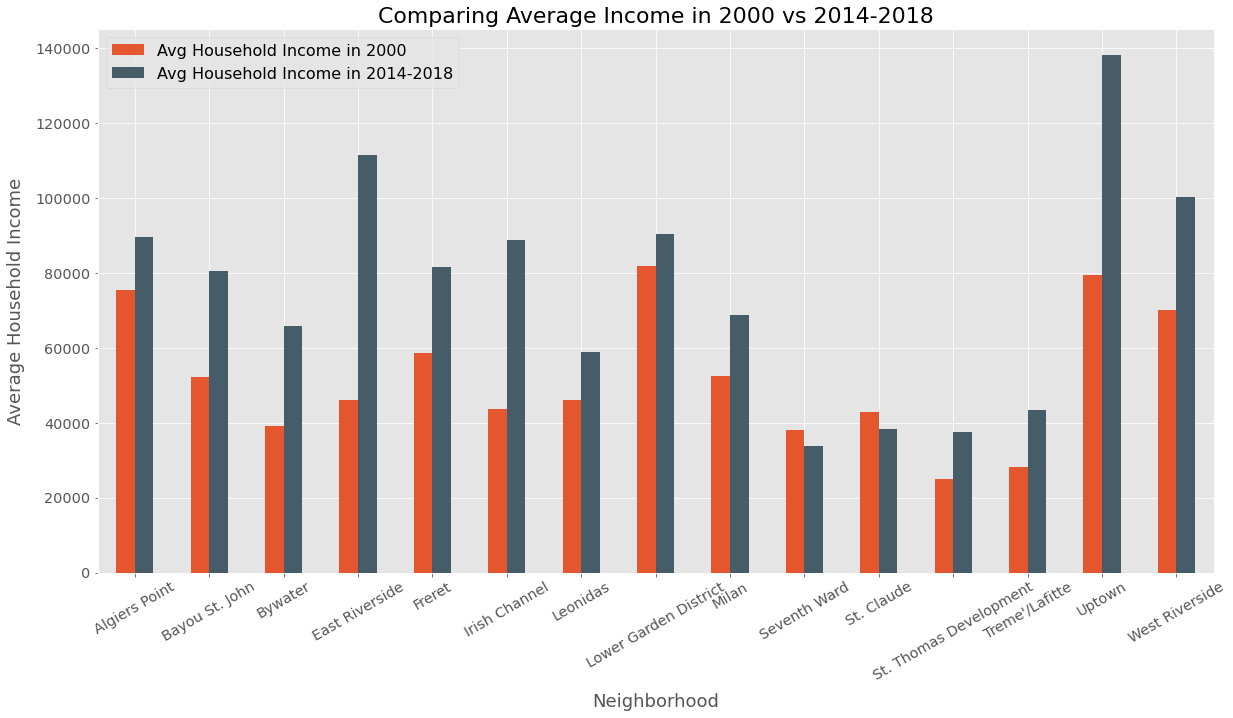

In [112]:
rand.shuffle(theme2)

#Comparing average income in 2000 vs 2014-2018
ax = avg_income_df[avg_income_df.Neighborhood.isin(highest_change)].plot.bar(
    x='Neighborhood', rot=30, figsize=(20,10), color=theme2, fontsize='x-large')

ax.set_title('Comparing Average Income in 2000 vs 2014-2018', fontsize=22)
ax.set_xlabel('Neighborhood', labelpad=10, fontsize=18)
ax.set_ylabel('Average Household Income', labelpad=10, fontsize=18)
ax.legend(fontsize=16)

From this graph, one can clearly deduce that in the majority of these neighborhoods, mean household income experienced a dramatic rise from 2000 to 2014-2018. This is consistent with what we know about gentrification since typically, wealthier people move into poorer neighborhoods, which would raise the average income significantly.

## Loading in and Cleaning More Datasets To Measure Gentrification
Now that we have the 15 neighborhoods which experienced the largest influx of White residents from 2000 to when a survey was conducted in 2014-2018, we can look at other factors other than pure racial distribution to determine whether this change in racial makeup is consistent with other factors of gentrification. <br><br>
**Datasets we will analyze:<br>**
`inc_dist_df`: This dataset breaks down income distribution into 16 categories for each neighborhood in both 2000 and 2014-2018. Plotting the data with this many categories made it difficult to show anything on the graph, so we decided to combine and redefine the boundaries for easier visualization<br>
`household`: Number of family households vs total households in each neighborhood spanning 2000 and 2014-2018<br>
`pov_df`: Percent of people living in poverty for each neighborhood spanning 2000 and 2014-2018<br>
`schooling_df`: Percent highest level of schooling  for each neighborhood spanning 2000 and 2014-2018<br>
`transport`: Access to personal vehicle for each neighborhood spanning 2000 and 2014-2018<br>
`wage`: Average monthly wage for each neighborhood in 2004-2017<br>
`pct_on_housing`: Percentage of renter-occupied and owner-occupied housing paying 30% of their income or more on housing for each neighborhood in 2014-2018 only
<br><br>
By looking at each of these datasets using the subset of neighborhoods which underwent the largest positive change in White residents, we can see the effects of gentrification.

In [113]:
#Loading and cleaning datasets related to measuring gentrification: 

#Cleaning income distribution data
inc_dist_df = pd.read_excel(xls, "Table 15", skiprows = 11)
inc_dist_df.drop(columns = ["Unnamed: 4", "Unnamed: 8", "Unnamed: 12", 
                            "Unnamed: 16", "Unnamed: 20", "Unnamed: 24","Unnamed: 28", "Unnamed: 32", 
                            "Unnamed: 36", "Unnamed: 40", "Unnamed: 44", "Unnamed: 48", "Unnamed: 52",
                            "Unnamed: 56", "Unnamed: 60", 
                            "MOE", "MOE.1", "MOE.2", "MOE.3", "MOE.4", "MOE.5", 
                            "MOE.6", "MOE.7", "MOE.8", "MOE.9", "MOE.10",
                            "MOE.11", "MOE.12", "MOE.13", "MOE.14", "MOE.15"], inplace=True)

inc_dist_df.rename(columns = { 
    "Unnamed: 0" : "Neighborhood",
    2000 : "Percent Income Under $10K in 2000", 
    "2000.1" : "Percent Income $10K-$15K in 2000",
    "2000.2" : "Percent Income $15K-$20K in 2000",
    "2000.3" : "Percent Income $20K-$25K in 2000",
    "2000.4" : "Percent Income $25K-$30K in 2000",
    "2000.5" : "Percent Income $30K-$35K in 2000",
    "2000.6" : "Percent Income $35K-$40K in 2000",
    "2000.7" : "Percent Income $40K-$45K in 2000",
    "2000.8" : "Percent Income $45K-$50K in 2000",
    "2000.9" : "Percent Income $50K-$60K in 2000",
    "2000.10" : "Percent Income $60K-$75K in 2000",
    "2000.11" : "Percent Income $75K-$100K in 2000",
    "2000.12" : "Percent Income $100K-$125K in 2000",
    "2000.13" : "Percent Income $125K-$150K in 2000",
    "2000.14" : "Percent Income $150K-$200K in 2000",
    "2000.15" : "Percent Income $200K+ in 2000",
    "2014-2018" : "Percent Income Under $10K in 2014-2018", 
    "2014-2018.1" : "Percent Income $10K-$15K in 2014-2018",
    "2014-2018.2" : "Percent Income $15K-$20K in 2014-2018",
    "2014-2018.3" : "Percent Income $20K-$25K in 2014-2018",
    "2014-2018.4" : "Percent Income $25K-$30K in 2014-2018",
    "2014-2018.5" : "Percent Income $30K-$35K in 2014-2018",
    "2014-2018.6" : "Percent Income $35K-$40K in 2014-2018",
    "2014-2018.7" : "Percent Income $40K-$45K in 2014-2018",
    "2014-2018.8" : "Percent Income $45K-$50K in 2014-2018",
    "2014-2018.9" : "Percent Income $50K-$60K in 2014-2018",
    "2014-2018.10" : "Percent Income $60K-$75K in 2014-2018",
    "2014-2018.11" : "Percent Income $75K-$100K in 2014-2018",
    "2014-2018.12" : "Percent Income $100K-$125K in 2014-2018",
    "2014-2018.13" : "Percent Income $125K-$150K in 2014-2018",
    "2014-2018.14" : "Percent Income $150K-$200K in 2014-2018",
    "2014-2018.15" : "Percent Income $200K+ in 2014-2018",
    }, inplace = True)

#Redefine bounds

inc_dist = inc_dist_df
dists = ['Percent Income Under $10K in 2000',
       'Percent Income Under $10K in 2014-2018',
         'Percent Income $10K-$35K in 2000',
         'Percent Income $10K-$35K in 2014-2018',
         'Percent Income $35K-$60K in 2000',
         'Percent Income $35K-$60K in 2014-2018',
         'Percent Income $60K-$100K in 2000',
         'Percent Income $60K-$100K in 2014-2018',
         'Percent Income $100K-$200K in 2000',
         'Percent Income $100K-$200K in 2014-2018',
         'Percent Income $200K+ in 2000', 'Percent Income $200K+ in 2014-2018']
inc_dist_col = ['Neighborhood'] + dists
inc_dist['Percent Income $10K-$35K in 2000'] = (
    inc_dist[ 'Percent Income $10K-$15K in 2000'] +
    inc_dist[ 'Percent Income $15K-$20K in 2000'] + 
    inc_dist['Percent Income $20K-$25K in 2000'] + 
    inc_dist['Percent Income $25K-$30K in 2000']+
    inc_dist['Percent Income $30K-$35K in 2000'])
inc_dist['Percent Income $35K-$60K in 2000'] = (
    inc_dist[ 'Percent Income $35K-$40K in 2000'] +
    inc_dist[ 'Percent Income $40K-$45K in 2000'] + 
    inc_dist['Percent Income $45K-$50K in 2000'] + 
    inc_dist['Percent Income $50K-$60K in 2000'])
inc_dist['Percent Income $60K-$100K in 2000'] = (
    inc_dist[ 'Percent Income $60K-$75K in 2000'] +
    inc_dist[ 'Percent Income $75K-$100K in 2000'])
inc_dist['Percent Income $100K-$200K in 2000']= (
    inc_dist[ 'Percent Income $100K-$125K in 2000'] +
    inc_dist[ 'Percent Income $125K-$150K in 2000'] + 
    inc_dist['Percent Income $150K-$200K in 2000'])

inc_dist['Percent Income $10K-$35K in 2014-2018'] = (
    inc_dist[ 'Percent Income $10K-$15K in 2014-2018'] +
    inc_dist[ 'Percent Income $15K-$20K in 2014-2018'] + 
    inc_dist['Percent Income $20K-$25K in 2014-2018'] + 
    inc_dist['Percent Income $25K-$30K in 2014-2018']+
    inc_dist['Percent Income $30K-$35K in 2014-2018'])
inc_dist['Percent Income $35K-$60K in 2014-2018'] = (
    inc_dist[ 'Percent Income $35K-$40K in 2014-2018'] +
    inc_dist[ 'Percent Income $40K-$45K in 2014-2018'] + 
    inc_dist['Percent Income $45K-$50K in 2014-2018'] + 
    inc_dist['Percent Income $50K-$60K in 2014-2018'])
inc_dist['Percent Income $60K-$100K in 2014-2018'] = (
    inc_dist[ 'Percent Income $60K-$75K in 2014-2018'] +
    inc_dist[ 'Percent Income $75K-$100K in 2014-2018'])
inc_dist['Percent Income $100K-$200K in 2014-2018']= (
    inc_dist[ 'Percent Income $100K-$125K in 2014-2018'] +
    inc_dist[ 'Percent Income $125K-$150K in 2014-2018'] + 
    inc_dist['Percent Income $150K-$200K in 2014-2018'])

#Loading and cleaning household data: shows family households and non-family households
household = pd.read_excel(xls, "Table 1", skiprows = 11)
household.drop(columns = ["Unnamed: 4","MOE", "MOE.1", "Unnamed: 8","MOE.2", 
                           2000, "2014-2018"], inplace=True)
household.rename(columns = { 
    "Unnamed: 0" : "Neighborhood",
    "2000.1" : "Total Households in 2000",
    "2014-2018.1" : "Total Households in  2014-2018",
    "2000.2" : "Family Households in 2000",
    "2014-2018.2" : "Family Households in 2014-2018"
    }, inplace = True)
household.dropna(inplace=True)

#Loading and cleaning poverty database: shows poverty rate in each neighborhood in 2 different periods
pov_df = pd.read_excel(xls, "Table 16", skiprows = 11)
pov_df.drop(columns = ["Unnamed: 4","MOE", "MOE.1"], inplace=True)
pov_df.rename(columns = { 
    "Unnamed: 0" : "Neighborhood",
    "2000.1" : "Pct at/above Poverty in 2000",
    "2014-2018.1" : "Pct at/above Poverty in 2014-2018",
    2000 : "Pct in Poverty in 2000",
    "2014-2018" : "Pct in Poverty in 2014-2018"
    }, inplace = True)
pov_df.dropna(inplace=True)

#Schooling data: divided into two graphs: finishing somewhere in high school vs college/above
school_df = pd.read_excel(xls, "Table 20", skiprows = 11)
school_df.drop(columns = ["Unnamed: 4", "Unnamed: 8", "Unnamed: 12", 
    "Unnamed: 16", "Unnamed: 20", "Unnamed: 24", "MOE", "MOE.1", "MOE.2", "MOE.3",
    "MOE.4", "MOE.5", "MOE.6"], inplace=True)

school_df.rename(columns = { 
    2000 : "<9th Grade in 2000",
    "2014-2018" : "<9th Grade in 2014-2018",
    "Unnamed: 0" : "Neighborhood",
    "2000.1" : "9-12th Grade in 2000",
    "2014-2018.1" : "9-12th Grade in 2014-2018",
    "2000.2" : "HS Diploma/GED in 2000",
    "2014-2018.2" : "HS Diploma/GED in 2014-2018",
    "2000.3" : "Some College in 2000",
    "2014-2018.3" : "Some College in 2014-2018",
    "2000.4" : "Associate's in 2000",
    "2014-2018.4" : "Associate's in 2014-2018",
    "2000.5" : "Bachelor's in 2000",
    "2014-2018.5" : "Bachelor's in 2014-2018",
    "2000.6" : "Graduate's and prof. in 2000",
    "2014-2018.6" : "Graduate's and prof. in 2014-2018",
    }, inplace = True)
school_df.dropna(inplace=True)

#highschool dataset
school_df_hs = school_df[['Neighborhood', '<9th Grade in 2000', 
        '<9th Grade in 2014-2018',
       '9-12th Grade in 2000', '9-12th Grade in 2014-2018',
       'HS Diploma/GED in 2000', 'HS Diploma/GED in 2014-2018']]

#university and beyond dataset
school_df_uni = school_df[['Neighborhood', 'Associate\'s in 2000', 
        'Associate\'s in 2014-2018', 'Bachelor\'s in 2000',
       'Bachelor\'s in 2014-2018', 'Graduate\'s and prof. in 2000',
       'Graduate\'s and prof. in 2014-2018']]

#Loading/cleaning transportation data: divide into access to a vehicle vs not
transport = pd.read_excel(xls, "Table 17", skiprows = 11)
transport.drop(columns = ["Unnamed: 4","MOE", "MOE.1", "Unnamed: 8","MOE.2", 
                          ], inplace=True)
transport.rename(columns = { 
    "Unnamed: 0" : "Neighborhood",
    2000: "No Vehicle in 2000",
    "2014-2018": "No Vehicle in 2014-2018",
    "2000.1" : "1 Vehicle in 2000",
    "2014-2018.1" : "1 Vehicle in 2014-2018",
    "2000.2" : "2+ Vehicles in 2000",
    "2014-2018.2" : "2+ Vehicles in 2014-2018"
    }, inplace = True)
transport.dropna(inplace=True)
transport[">=1 Vehicle in 2000"] = transport["1 Vehicle in 2000"] + transport["2+ Vehicles in 2000"]
transport[">=1 Vehicle in 2014-2018"] = (transport["1 Vehicle in 2014-2018"] +
                                         transport["2+ Vehicles in 2014-2018"]
)

#Loading/Cleaning Monthly wage dataset
wage = pd.read_excel(xls, "Table 22", skiprows = 11)
wage.drop(columns = [2004,         2017, 'Unnamed: 3','Unnamed: 6','Unnamed: 9'], inplace=True)
wage.rename(columns = { 
    "Unnamed: 0" : "Neighborhood",
    "2004.1" : "<=$1,250/month in 2004",
    "2017.1" : "<=$1,250/month in 2017",
    "2004.2" : "$1,251 - $3,333/month in 2004",
    "2017.2" : "$1,251 - $3,333/month in 2017",
    "2004.3" : ">$3,333/month in 2004",
    "2017.3" : ">$3,333/month in 2017",
    }, inplace = True)
wage.dropna(inplace=True)

# Cleaning percent of income spent on housing data for owner-occupied vs renter-occupied
pct_on_housing = pd.read_excel(xls, "Table 12", skiprows = 11)
pct_on_housing.drop(columns = ["Unnamed: 3","MOE", "MOE.1"], inplace=True)
pct_on_housing.rename(columns = { 
    "Unnamed: 0" : "Neighborhood",
    "2014-2018.1" : "Renter Occ paying >=30%",
    "2014-2018" : "Owner Occ paying >=30%"
    }, inplace = True)
pct_on_housing.dropna(inplace=True)

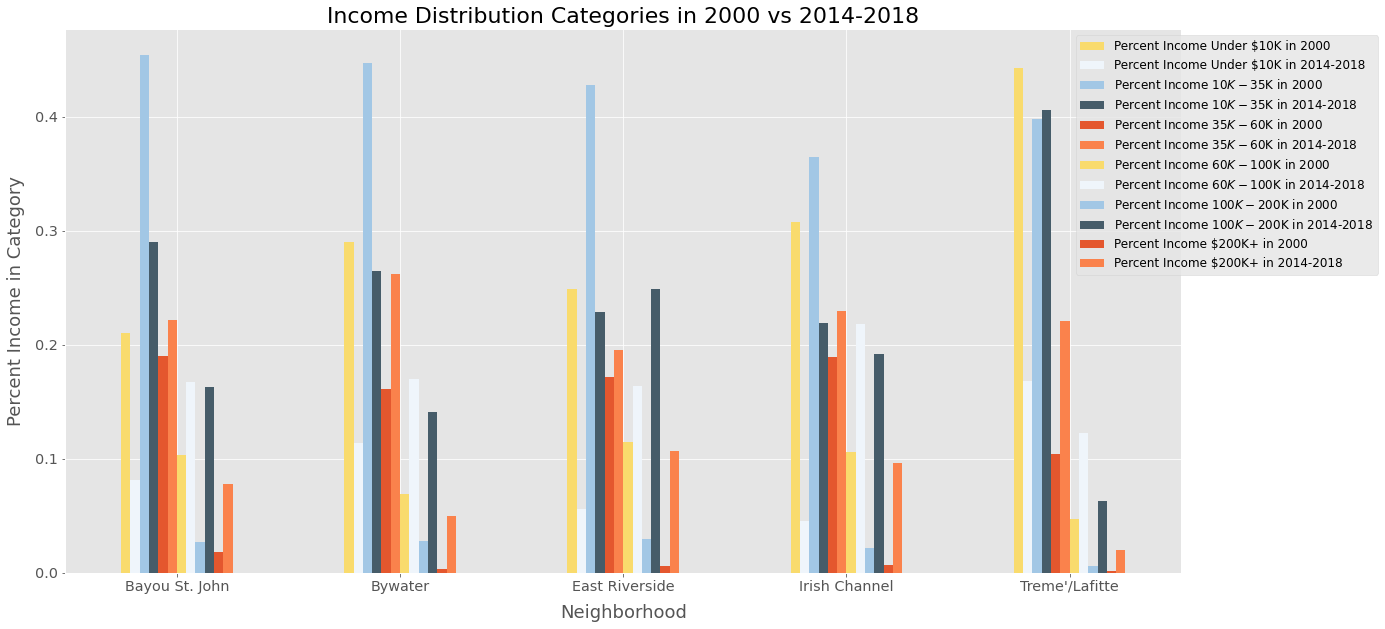

In [114]:
#Plotting these features:

#Income distribution categories in 2000 vs 2014-2018
#*Note: selected a subset of 5 neighborhoods to better view information

theme2 = ['#f9db6d', '#eff5fb', '#a2c7e5', '#465c69', '#e4572e', '#fa824c']

ax = inc_dist[inc_dist_df.Neighborhood.isin(highest_change[:5])][inc_dist_col].plot.bar(
    x='Neighborhood', rot=0, figsize=(20,10), color=theme2, fontsize='x-large')

#Titles/legend
ax.set_title('Income Distribution Categories in 2000 vs 2014-2018', fontsize=22)
ax.set_xlabel('Neighborhood', labelpad=10, fontsize=18)
ax.set_ylabel('Percent Income in Category', labelpad=10, fontsize=18)
ax.legend(bbox_to_anchor=(.9, 1), fontsize=12)


From this graph, we chose to show a subset of only 5 of the 15 neighborhoods in order to more clearly show the distributions. Looking at the different columns, it's clear that Percent Income Under \\$10K and Percent Income between \\$10K-35K dropped dramatically from the first of the two time periods to the second. In the same vein, the percentages of higher income brackets increased substantially. This is also consistent with the impact of gentrification on a neighborhood because gentrification attracts residents from higher income brackets than in previous years, so we would expect the percentage of residents making \\$100K or more to increase.

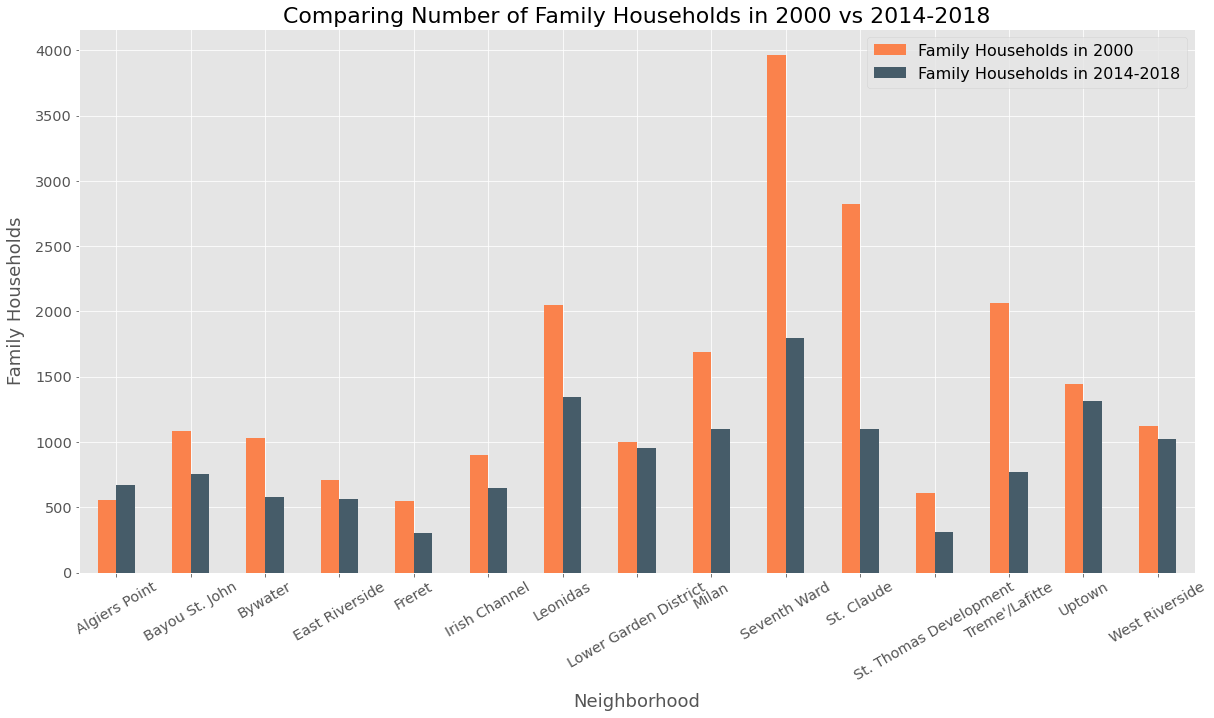

In [115]:
rand.shuffle(theme2)

#Comparing household types in 2000 vs 2014-2018

ax = household[household.Neighborhood.isin(highest_change)][['Neighborhood','Family Households in 2000',
                         'Family Households in 2014-2018']].plot.bar(x='Neighborhood', rot=30, 
                                            figsize=(20,10), color=theme2, fontsize='x-large')
#Titles/legend
ax.set_title('Comparing Number of Family Households in 2000 vs 2014-2018', fontsize=22)
ax.set_xlabel('Neighborhood', labelpad=10, fontsize=18)
ax.set_ylabel('Family Households', labelpad=10, fontsize=18)
ax.legend(fontsize=16)

From this graph, we can see that the number of family households in most of the neighborhoods shown decreased from 2000 to 2014-2018. One possible explanation for this would be that when an area becomes gentrified, investors will often buy properties low, expecting them to shoot up in value. These investor-owned properties would then displace some of the family households previously residing in each neighborhood. Therefore, this dataset is consistent with gentrification in these neighborhoods as well.

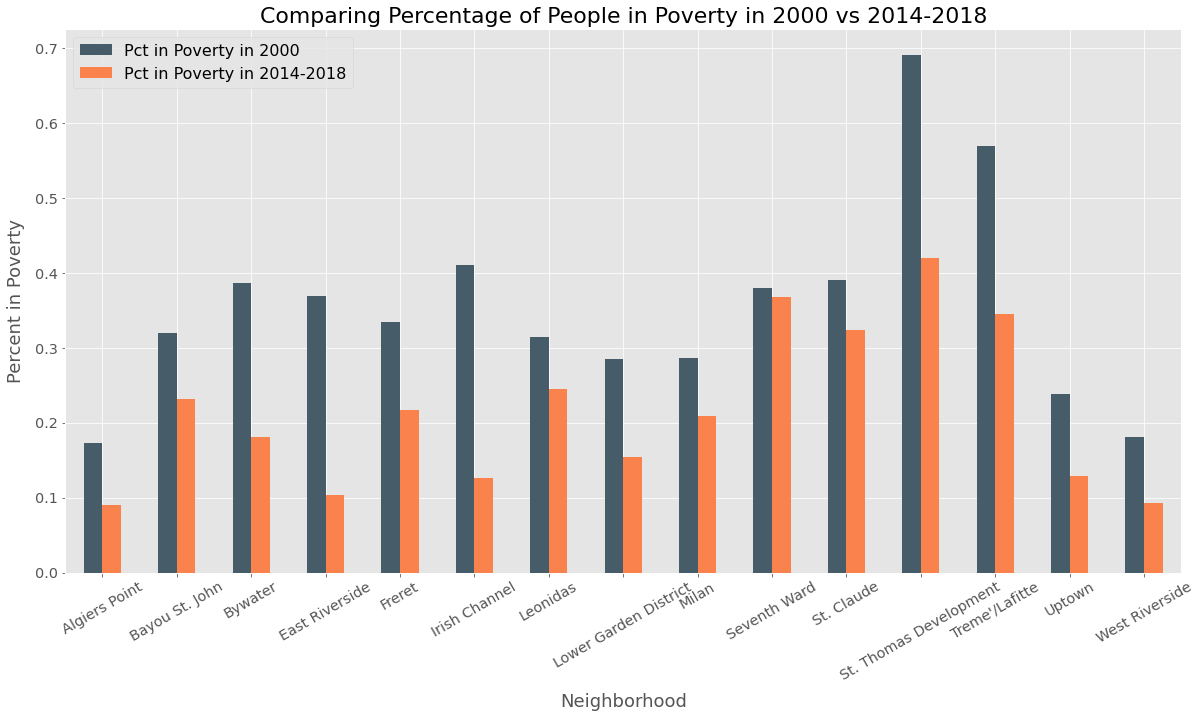

In [116]:
rand.shuffle(theme2)

#Comparing number in poverty in 2000 vs 2014-2018

ax = pov_df[pov_df.Neighborhood.isin(highest_change)][['Neighborhood',
                    "Pct in Poverty in 2000", "Pct in Poverty in 2014-2018"]].plot.bar(x='Neighborhood', 
                                            rot=30, figsize=(20,10), color=theme2, fontsize='x-large')
#Titles/legend
ax.set_title('Comparing Percentage of People in Poverty in 2000 vs 2014-2018', fontsize=22)
ax.set_xlabel('Neighborhood', labelpad=10, fontsize=18)
ax.set_ylabel('Percent in Poverty', labelpad=10, fontsize=18)
ax.legend(fontsize=16)


From this graph, we can see that the percentage of residents living in poverty decreased quite a bit from 2000 to 2014-2018. This is consistent with what we know about gentrification as well, since, as we mentioned previously, wealthier residents displace poorer residents, causing the poverty rate to fall.

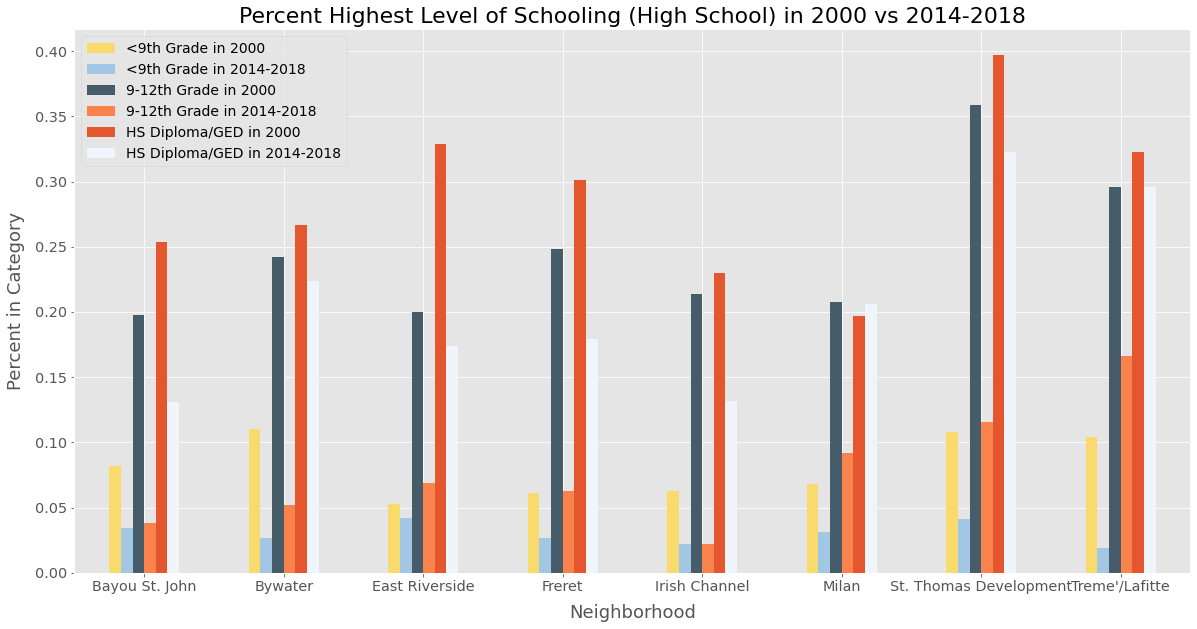

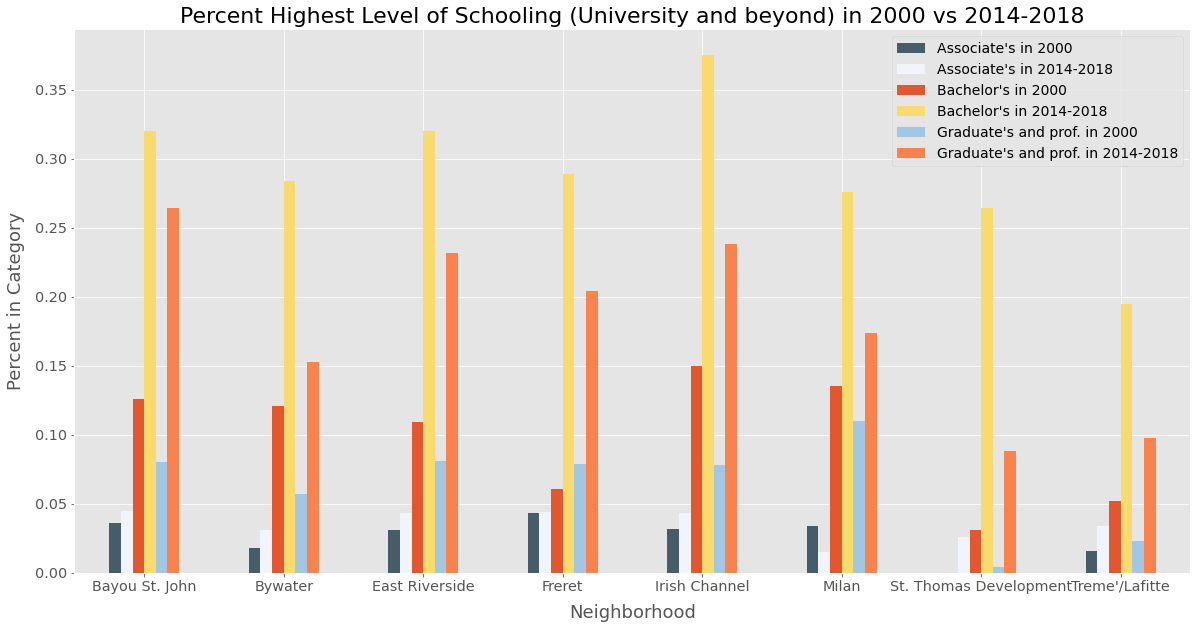

In [117]:
rand.shuffle(theme2)

#Comparing highest level of schooling in 2000 vs 2014-2018
#*Note: selected a subset of 5 neighborhoods to better view information

#Schooling ended somewhere in high school

ax1 = school_df_hs[school_df_hs.Neighborhood.isin(highest_change[:8])].plot.bar(
    x='Neighborhood', rot=0, figsize=(20,10), color=theme2, fontsize='x-large')

#Titles/legend
ax1.set_title('Percent Highest Level of Schooling (High School) in 2000 vs 2014-2018', 
                                                                                  fontsize=22)
ax1.set_xlabel('Neighborhood', labelpad=10, fontsize=18)
ax1.set_ylabel('Percent in Category', labelpad=10, fontsize=18)
ax1.legend(fontsize=14)

rand.shuffle(theme2)

#Schooling ended somewhere in college

ax2 = school_df_uni[school_df_uni.Neighborhood.isin(highest_change[:8])].plot.bar(
    x='Neighborhood', rot=0, figsize=(20,10), color=theme2, fontsize='x-large')

#Titles/legend
ax2.set_title('Percent Highest Level of Schooling (University and beyond) in 2000 vs 2014-2018', 
                                                                                          fontsize=22)
ax2.set_xlabel('Neighborhood', labelpad=10, fontsize=18)
ax2.set_ylabel('Percent in Category', labelpad=10, fontsize=18)
ax2.legend(fontsize=14)



I find this graph very interesting. Since there were so many different categories in this dataset, I found the best way to visualize what it's showing was to separate the categories into two different graphs: the highest level of schooling ending somewhere in high school, and the highest level of schooling ending somewhere in university or even higher education. In order to be able to see the columns, there are only 8 neighborhoods represented instead of 15.<br>

That being said, looking at the first graph, it is clear that the percentage of residents terminating their formal education anywhere in high school decreased significantly from 2000 to 2014-2018. This is consisten with the second graph as well, since the percentage of college or higher-educated individuals shot up by 2018. This makes a lot of sense in terms of gentrification because we would expect wealthier, more highly educated residents to displace those that lived there previously.

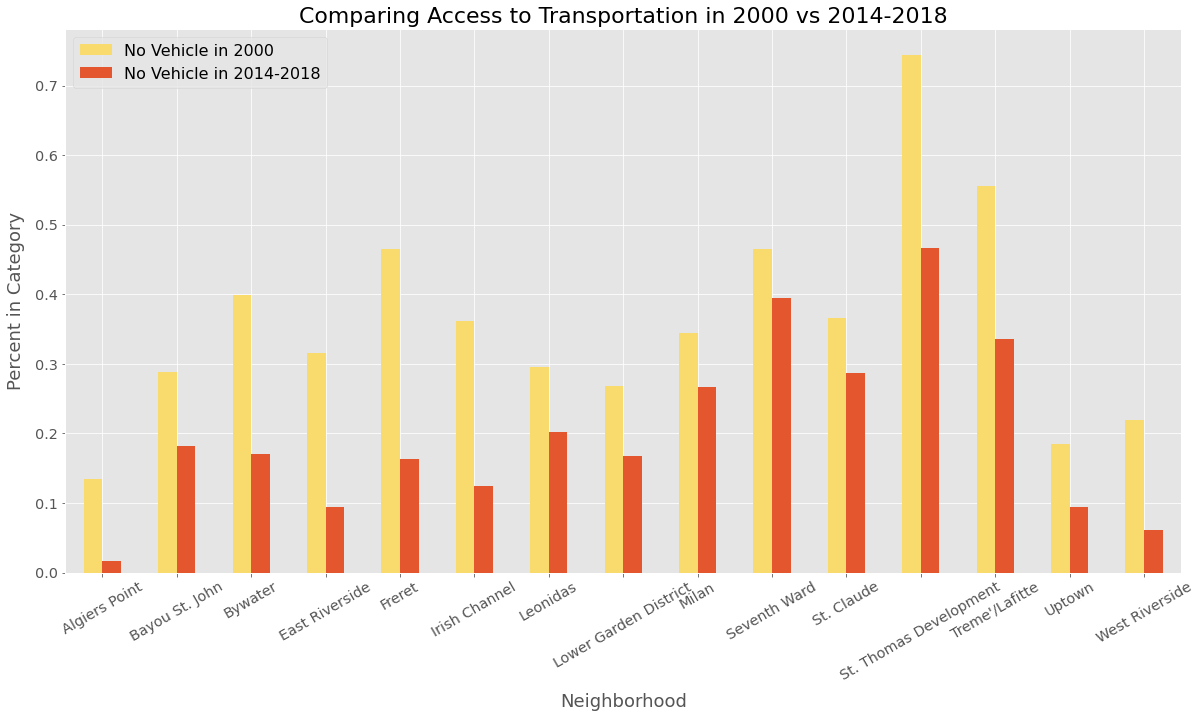

In [118]:
rand.shuffle(theme2)

#Comparing access to transportation in 2000 vs 2014-2018

ax = transport[transport.Neighborhood.isin(highest_change)][['Neighborhood', "No Vehicle in 2000", 
                                        "No Vehicle in 2014-2018"]].plot.bar(x='Neighborhood', rot=30, 
                                                figsize=(20,10), color=theme2, fontsize='x-large')

#Titles/legend
ax.set_title('Comparing Access to Transportation in 2000 vs 2014-2018', fontsize=22)
ax.set_xlabel('Neighborhood', labelpad=10, fontsize=18)
ax.set_ylabel('Percent in Category', labelpad=10, fontsize=18)
ax.legend(fontsize=16)

From this graph, we can see that the percentage of residents without access to a vehicle decreased significantly from 2000 to 2014-2018. This indicates the potential presence of gentrification since wealthier residents are more likely to own one or more vehicles.

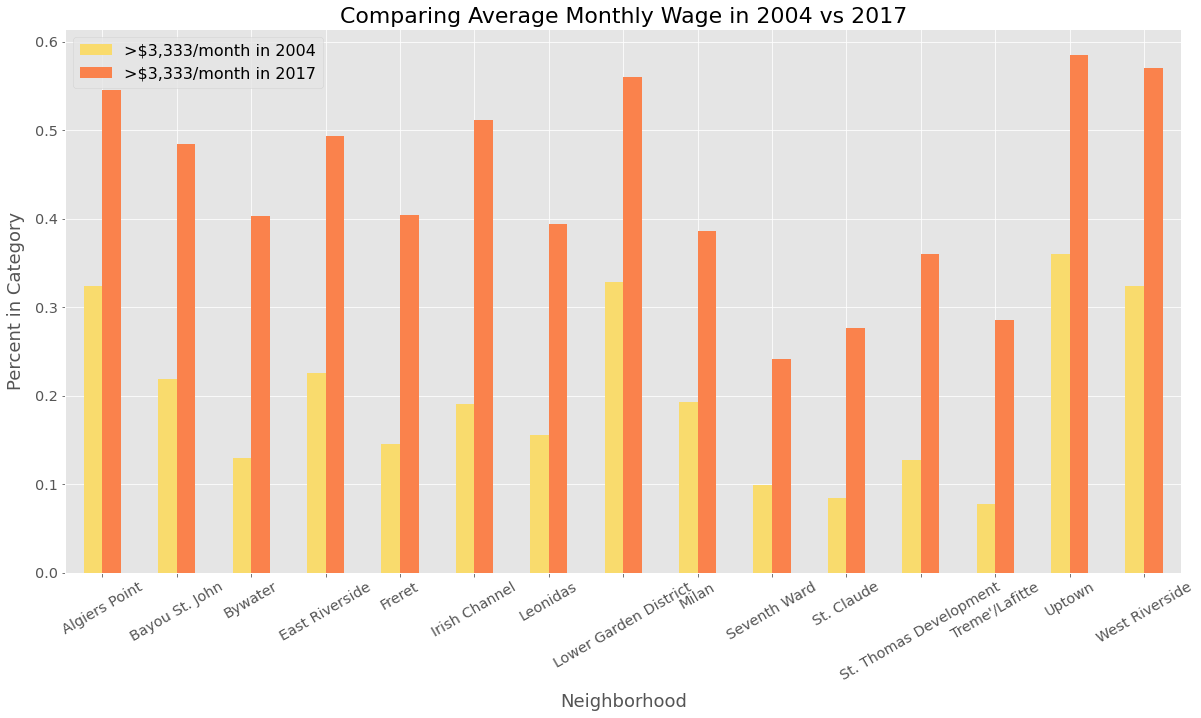

In [119]:
rand.shuffle(theme2)

#Comparing monthly wage in 2000 vs 2014-2018

ax = wage[wage.Neighborhood.isin(highest_change)][['Neighborhood', '>$3,333/month in 2004', 
                                    '>$3,333/month in 2017']].plot.bar(
    x='Neighborhood', rot=30, figsize=(20,10), color=theme2, fontsize='x-large')

#Titles/legend
ax.set_title('Comparing Average Monthly Wage in 2004 vs 2017', fontsize=22)
ax.set_xlabel('Neighborhood', labelpad=10, fontsize=18)
ax.set_ylabel('Percent in Category', labelpad=10, fontsize=18)
ax.legend(fontsize=16)


This graph divides the population in each neighborhood into workers who make over \\$3,333 per month and those who do not. The huge increase of these high-earning workers from 2004 to 2017 indicates that gentrification is likely present in these neighborhoods.

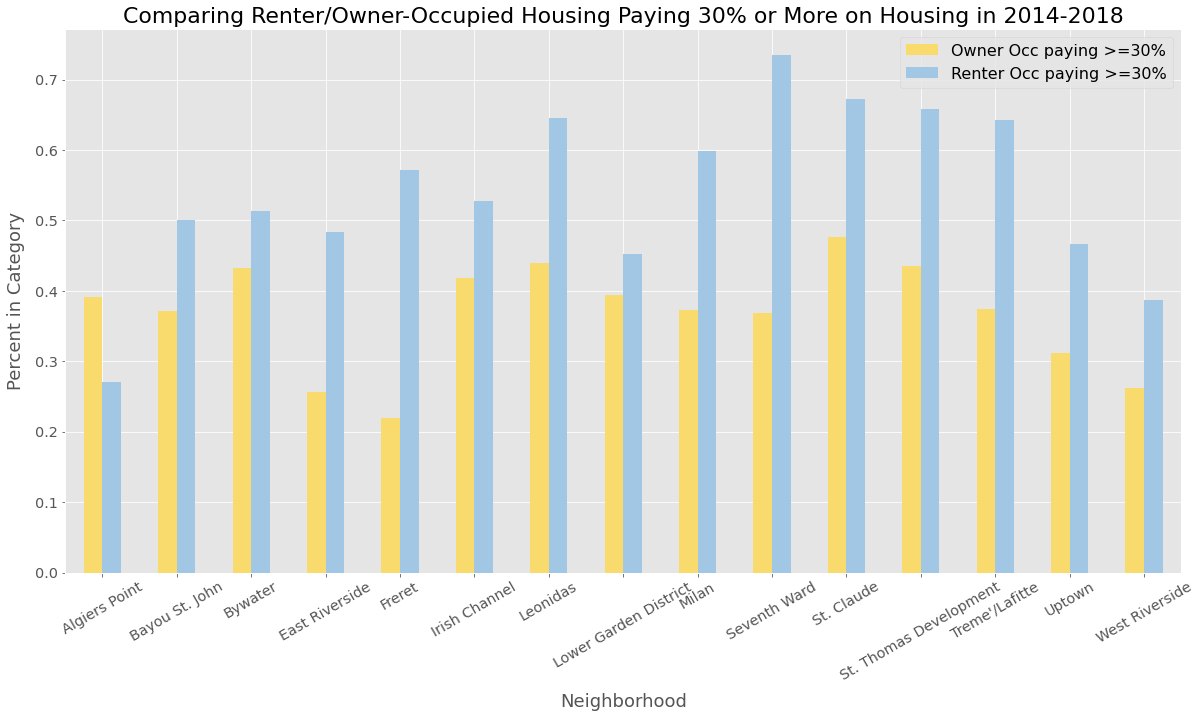

In [120]:
rand.shuffle(theme2)

#Comparing percent of income spent on housing in 2000 vs 2014-2018

ax = pct_on_housing[pov_df.Neighborhood.isin(highest_change)].plot.bar(
    x='Neighborhood', rot=30, figsize=(20,10), color=theme2, fontsize='x-large')

#Titles/legend
ax.set_title(
    'Comparing Renter/Owner-Occupied Housing Paying 30% or More on Housing in 2014-2018', 
                                                                                        fontsize=22)
ax.set_xlabel('Neighborhood', labelpad=10, fontsize=18)
ax.set_ylabel('Percent in Category', labelpad=10, fontsize=18)
ax.legend(fontsize=16)

This graph represents those spending 30% or more of their annual income on housing and divides them into two categories: Owner-Occupied housing and Renter-Occupied housing. Since this dataset only had data from 2014-2018, we cannot compare the change over the two time periods. However, there are still interesting insights to pull from this. First of all, there is already a relatively high proportion of people paying 30% of their income or more on housing, which speaks to the affordability (or lack there of) of housing in these neighborhoods. Additionally, in almost all cases, there is a larger percentage of Renter-Occupied housing paying at or above 30% of their income on housing than Owner-Occupied housing. In one of the earlier graphs, we mentioned that the decrease in family households suggests that many of the households are owned by investors who buy properties at a low value and charge a high rent. This is evident based on the data displayed in this graph.

# Conclusion

In conclusion, we found that census tracts with 40% - 60% black residents are most vulnerable to gentrification. This range represents a "bliss point" at which white residents are comfortable moving into a neighborhood. Before this point, very little gentrification can be seen. While we didn't have data on many other factors relating directly to census tracts, we corroborated our hypothesis by analyzing similar data at a higher level, relating what we found to New Orleans neighborhoods. The neighborhood profiles data from the data center allowed us to confirm our suspicions: that this large influx in white residents had a strong impact on other socioeconomic factors on those that lived there. Moving forward from here, there is more that we can do in terms of identifying gentrification in New Orleans. Another dataset that would be interesting to look into would be to track unemployment rates by year and see which areas are being hit the hardest. Another way to measure gentrification would be using data on small businesses. It would be interesting to track how well White business owners do in comparison to those that are Black. We could also measure the proximity of new, upscale businesses to surrounding neighborhoods and measure the effects pouring out into those areas. <br><br>
Overall, this project has brought to my attention both how prevalent gentrification is in New Orleans, and how detrimental it can be to the residents facing it. There is so much more we can do, but drawing attention to the problem is definitely the first step.